# Khan 2018 Mouse Lens Re-analysis

## Quality control and sanity check notebook

### performed by Phil Wilmarth, PSR Core OHSU

#### August 29, 2023

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Removing plex effects with IRS](#IRS)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a three plex experiment using 10-plex TMT with no reference channels per plex. Each plex is a set of biological replicates of developing mouse lens: E15, E18, P0, P3, P6, P9 (six ages, 3 day intervals). Data were downloaded from PRIDE (PXD006381) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the average of each plex as a mock reference channel. This is the publication:

> Khan, S.Y., Ali, M., Kabir, F., Renuse, S., Na, C.H., Talbot, C.C., Hackett, S.F. and Riazuddin, S.A., 2018. Proteome profiling of developing murine lens through mass spectrometry. Investigative Ophthalmology & Visual Science, 59(1), pp.100-107.

This QC notebook will address these questions:

- Does internal reference scaling (IRS) (*Plubell 2017*) remove TMT plex "batch effects"?
- Do the samples cluster by biological group?
- Are normalization factors small and consistent?
- Are samples within groups similar to each other?

#### Experimental Groups:

Age|Description|Biological Replicates|Pooled Mice Lenses
---|---|---|---
E15|Embryonic day 15|3|23 embryos
E18|Embryonic day 18|3|10 embryos
P0|Newborn|3|8 pups
P3|3-day old|3|8 pups
P6|6-day old|3|8 pups
P9|9-day old|3|8 pups

#### Sample Key:

Channel|Plex 1|Plex 2|Plex 3
---|---|---|---
126C|E15|E15|E15
127N|E18|E18|E18
127C|P0|P0|P0
128N|P3|P3|P3
128C|P6|P6|P6
129N|P9|P9|P9
129C|Mix?|Mix?|Mix?
130N|unused|unused|unused
130C|unused|unused|unused
131N|unused|unused|unused

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

---

## This notebook examines quality control metrics

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the IRS-normalized TMT intensity data

The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is relatively straightforward.

We need to drop contaminant and decoy proteins, and proteins with missing sets of reporter ions. We extract the accessions column, the SLNorm data columns, and IRSNorm data columns. 

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", 
                        guess_max = 5854)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))
data_sl <- select(data_all, contains("SLNorm_"))
data_irs <- select(data_all, contains("IRSNorm_"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.



[1] 4249

### Collect channels by biological conditions 

We also get the mock reference channels (plex averages) to check the IRS procedure.

In [4]:
# define the groups (before IRS)
E15_sl <- select(data_sl, contains("_E15_"))
E18_sl <- select(data_sl, contains("_E18_"))
P0_sl <- select(data_sl, contains("_P0_"))
P3_sl <- select(data_sl, contains("_P3_"))
P6_sl <- select(data_sl, contains("_P6_"))
P9_sl <- select(data_sl, contains("_P9_"))

# define the groups (after IRS)
E15_irs <- select(data_irs, contains("_E15_"))
E18_irs <- select(data_irs, contains("_E18_"))
P0_irs <- select(data_irs, contains("_P0_"))
P3_irs <- select(data_irs, contains("_P3_"))
P6_irs <- select(data_irs, contains("_P6_"))
P9_irs <- select(data_irs, contains("_P9_"))

# get the pooled standards for QC checks
pools_before <- select(data_sl, contains("_Pool_"))
pools_after <- select(data_irs, contains("_Pool_"))

### Make the organized data frames

We will put the organized data into some new "before and after" data frames, define some column indexes for each biological group, and set some colors for plotting.

In [5]:
# put groups together into a single data frame
tmt_sl <- bind_cols(E15_sl, E18_sl, P0_sl, P3_sl, P6_sl, P9_sl, pools_before)
tmt_irs <- bind_cols(E15_irs, E18_irs, P0_irs, P3_irs, P6_irs, P9_irs, pools_after)

In [6]:
# define which columns go with each group
E15 <- 1:3
E18 <- 4:6
P0 <- 7:9
P3 <- 10:12
P6 <- 13:15
P9 <- 16:18
pool <- 19:21

# set some colors by group
colors_group = c(rep('dark red', 3), rep('red', 3), rep('dark blue', 3), rep('blue', 3), 
                 rep('dark green', 3), rep('green', 3), rep('black', 3))

# set colors by plex
colors_before = c(rep(c('red', 'blue', 'green'), 7))

## <a name="IRS"></a>Clustering before and after IRS

We expect to see each of the 3 plexes cluster by plex before IRS. The plex batch-like effect should be removed by the IRS method and the clustering after IRS should be by biological groups.

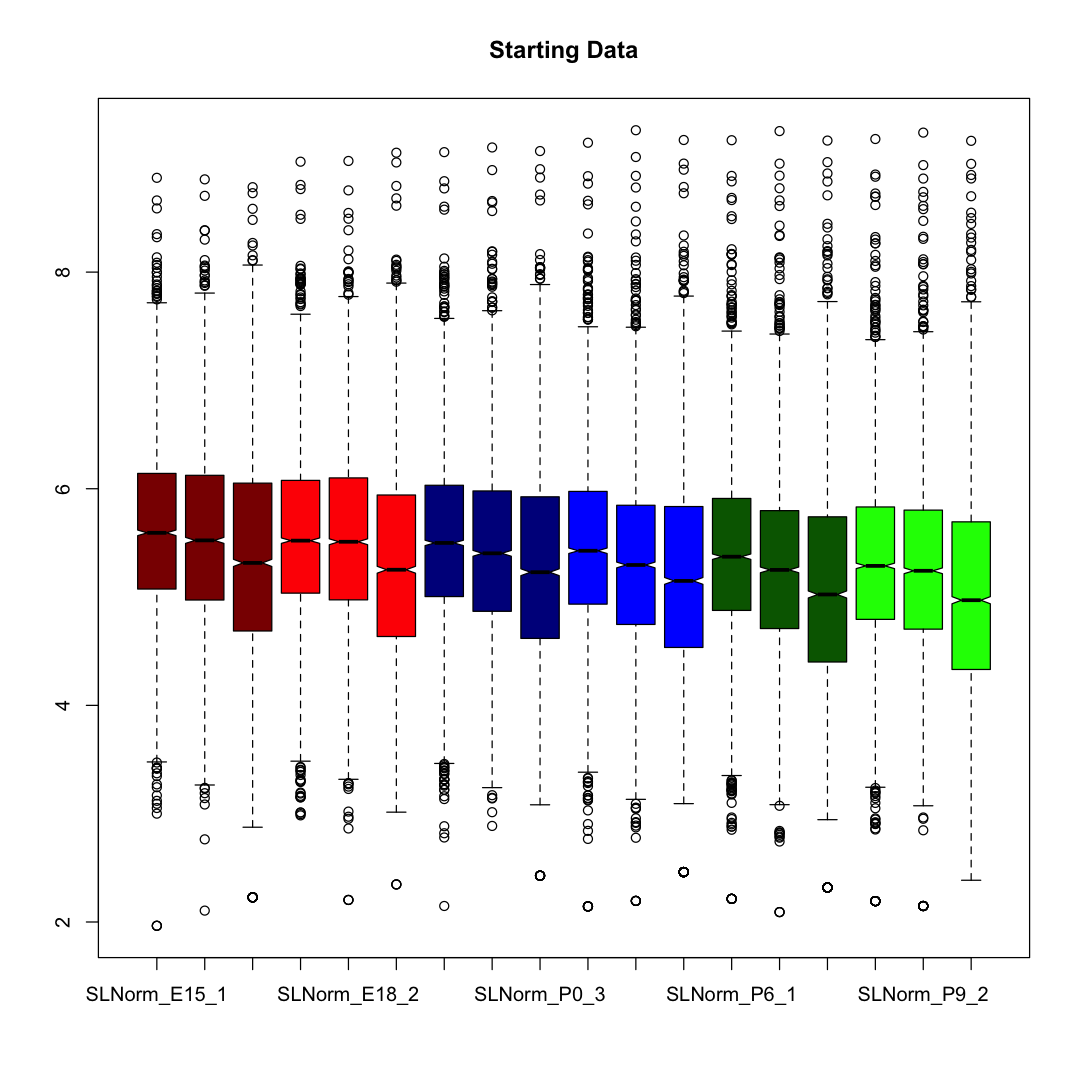

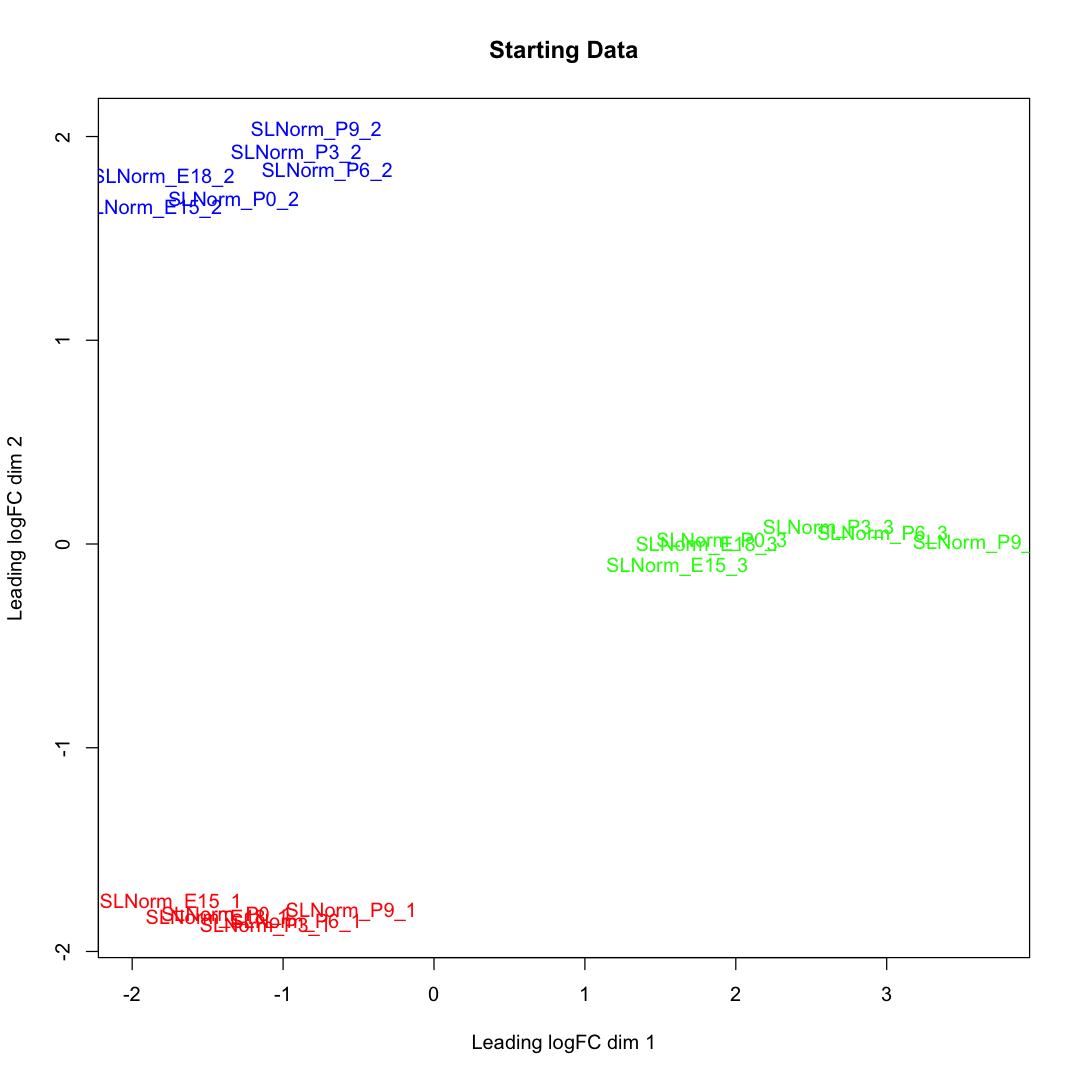

In [7]:
# make default plot sizes a little bigger
set_plot_dimensions(9, 9)

# check starting intensity distributions
boxplot(log10(tmt_sl[1:18]), col = colors_group, notch = TRUE, main = "Starting Data")

# check clustering before IRS
plotMDS(log2(tmt_sl[1:18]), main = "Starting Data", col = colors_before)

### Samples cluster by TMT plex

We have 6 samples (ages) per plex (each plex is a different color). Within each plex cluster, there is a left-to-right trend with E15 on the left and P9 on the right. The differences by age within each plex are much smaller than the differences between plexes. This data is not suitable for statistical testing.

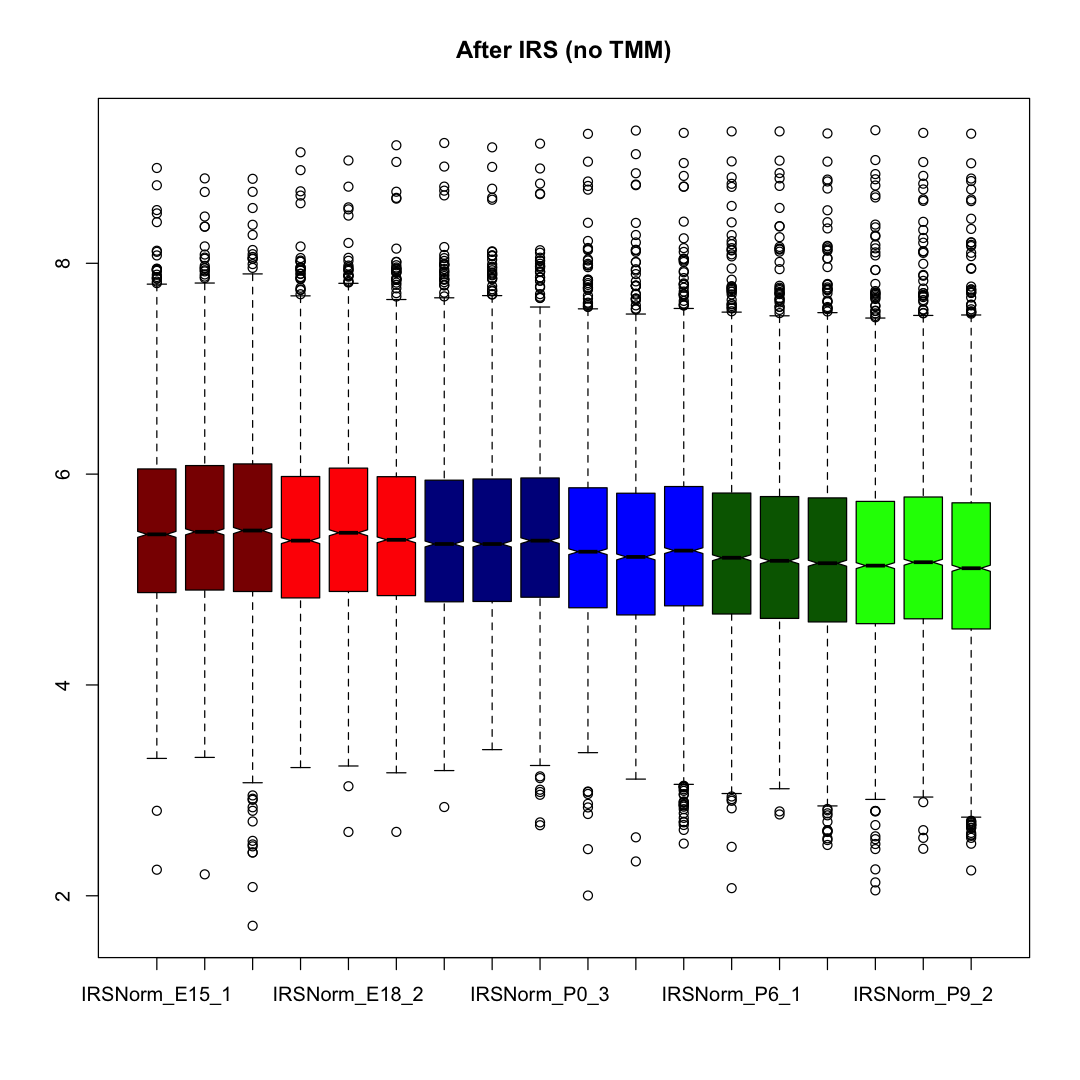

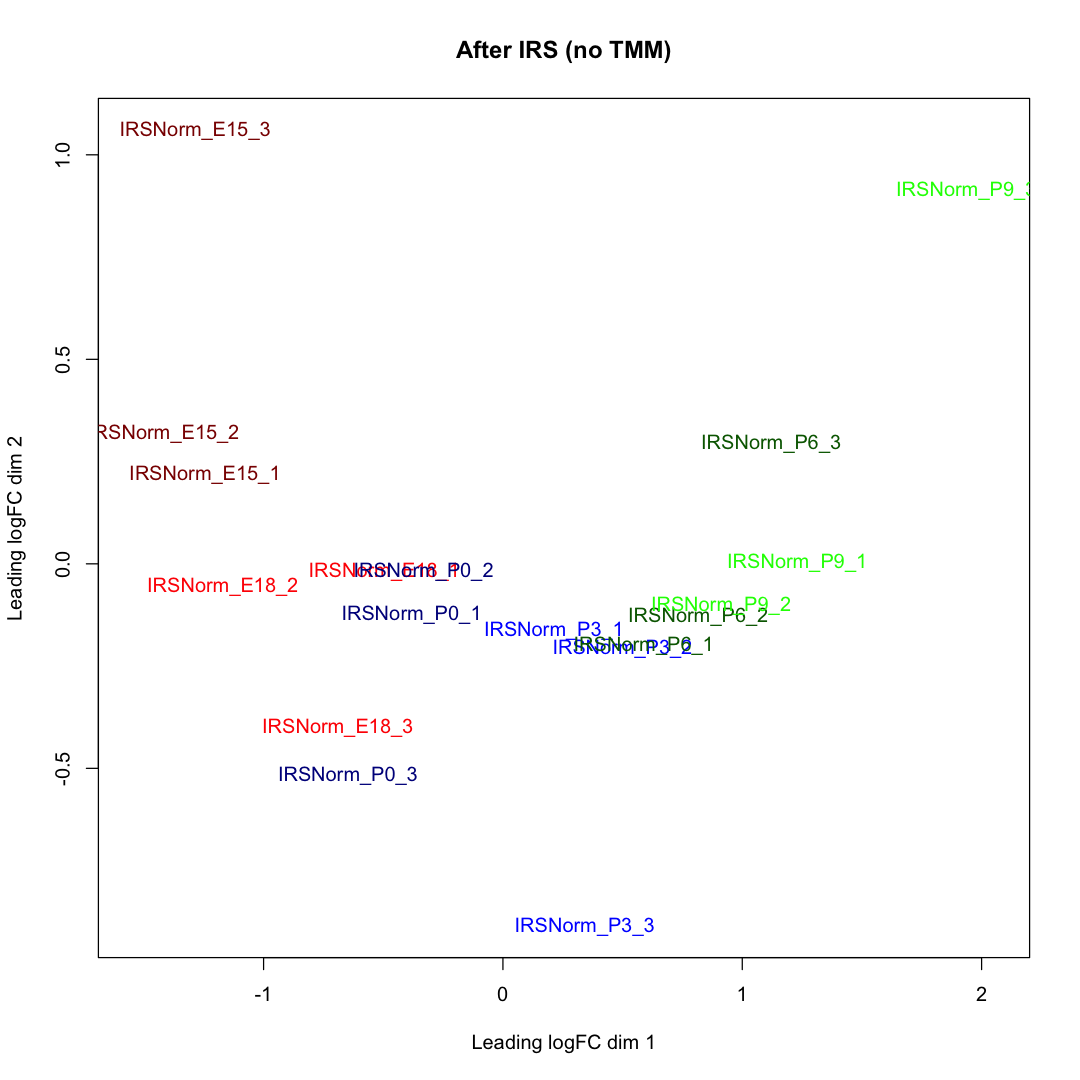

In [8]:
# boxplots after IRS and before TMM
boxplot(log10(tmt_irs[1:18]), col = colors_group, notch = TRUE, main = "After IRS (no TMM)")

# clustering after IRS
plotMDS(log2(tmt_irs[1:18]), main = "After IRS (no TMM)", col = colors_group)

### IRS removes the TMT plex effect

We do not have the plex structure anymore after IRS. There is a left (young) to right (older) separation by age. In each developmental age cluster, we see plex 1 and 2 closer together than plex 3. Plex 3 had poorer instrument performance resulting in fewer identified PSMs/proteins and reduced reporter ion intensities.

## Check the mock reference channels before and after IRS

The intensities after IRS should be identical because the IRS method will make all the reference protein intensities the same. In the before IRS figure, reference channels are very different between plexes. The scatter between plexes is because of the random selection for MS2 scans. This is highly variable feature-by-feature and would not be similar between LC runs or TMT plexes. The IRS method removes that variation. 

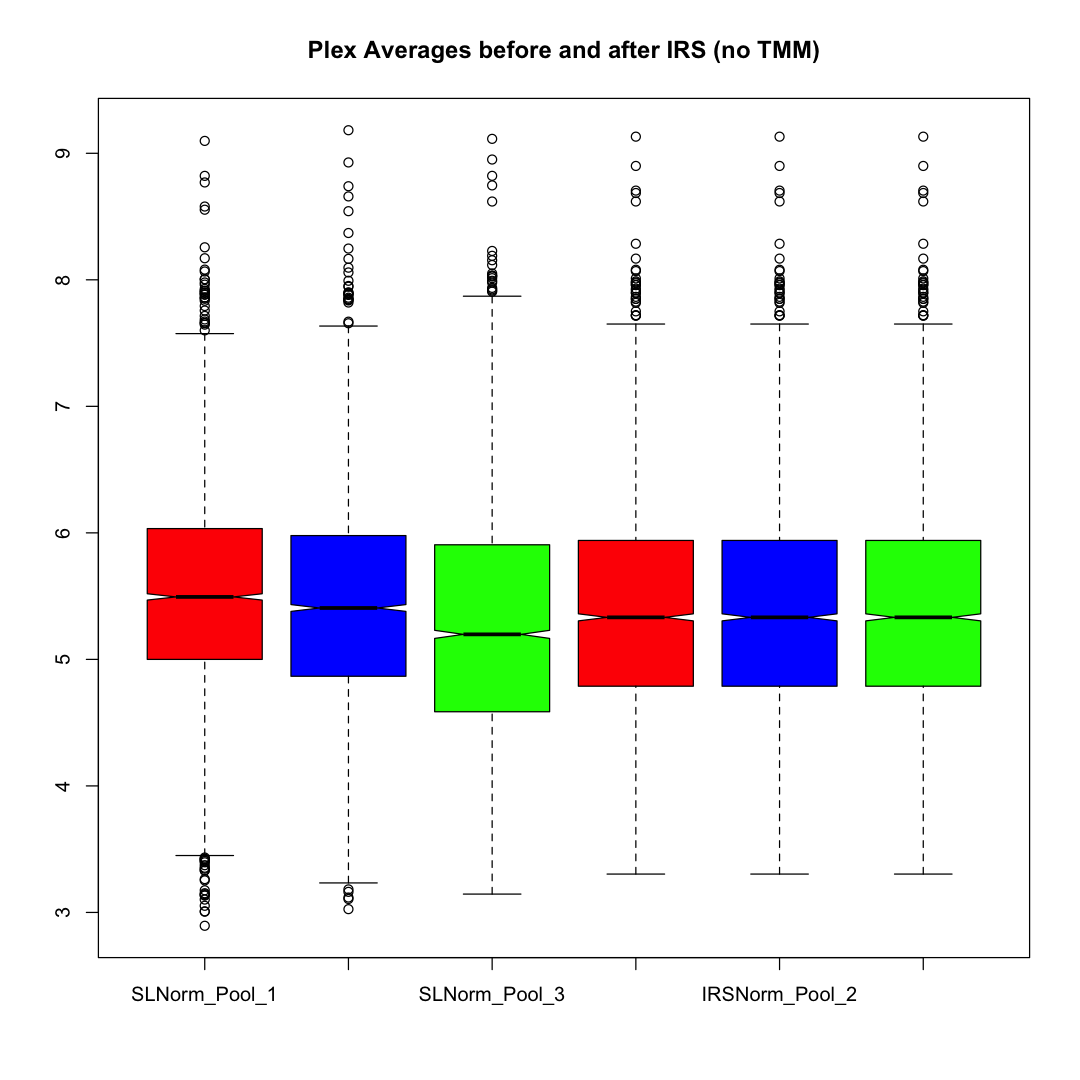

In [9]:
# boxplots of intensity distributions
before_after <- cbind(tmt_sl[19:21], tmt_irs[19:21])
boxplot(log10(before_after), col = colors_before, notch = TRUE, 
        main = "Plex Averages before and after IRS (no TMM)")

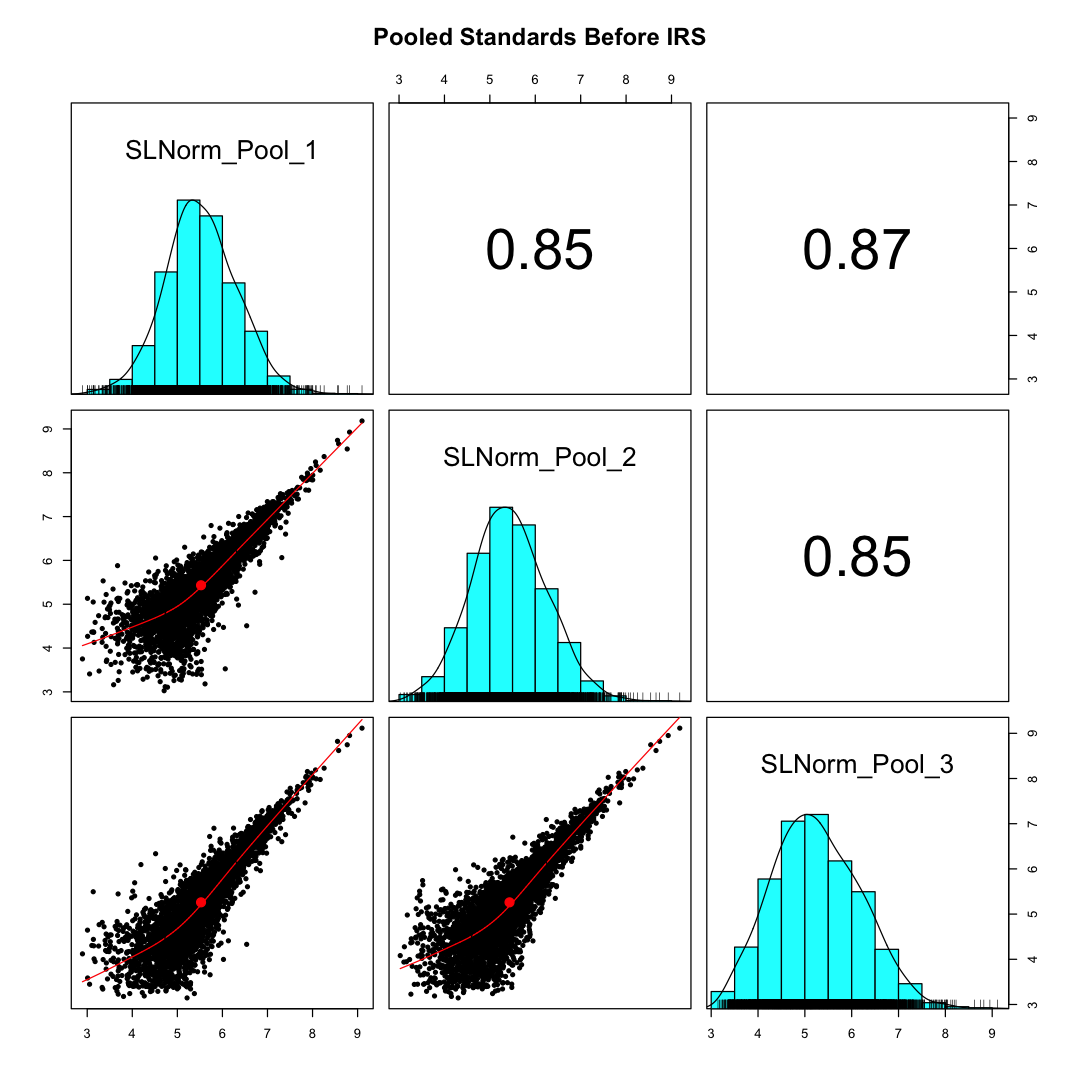

In [10]:
# check the internal reference standard channels
pairs.panels(log10(pools_before), main = "Pooled Standards Before IRS")

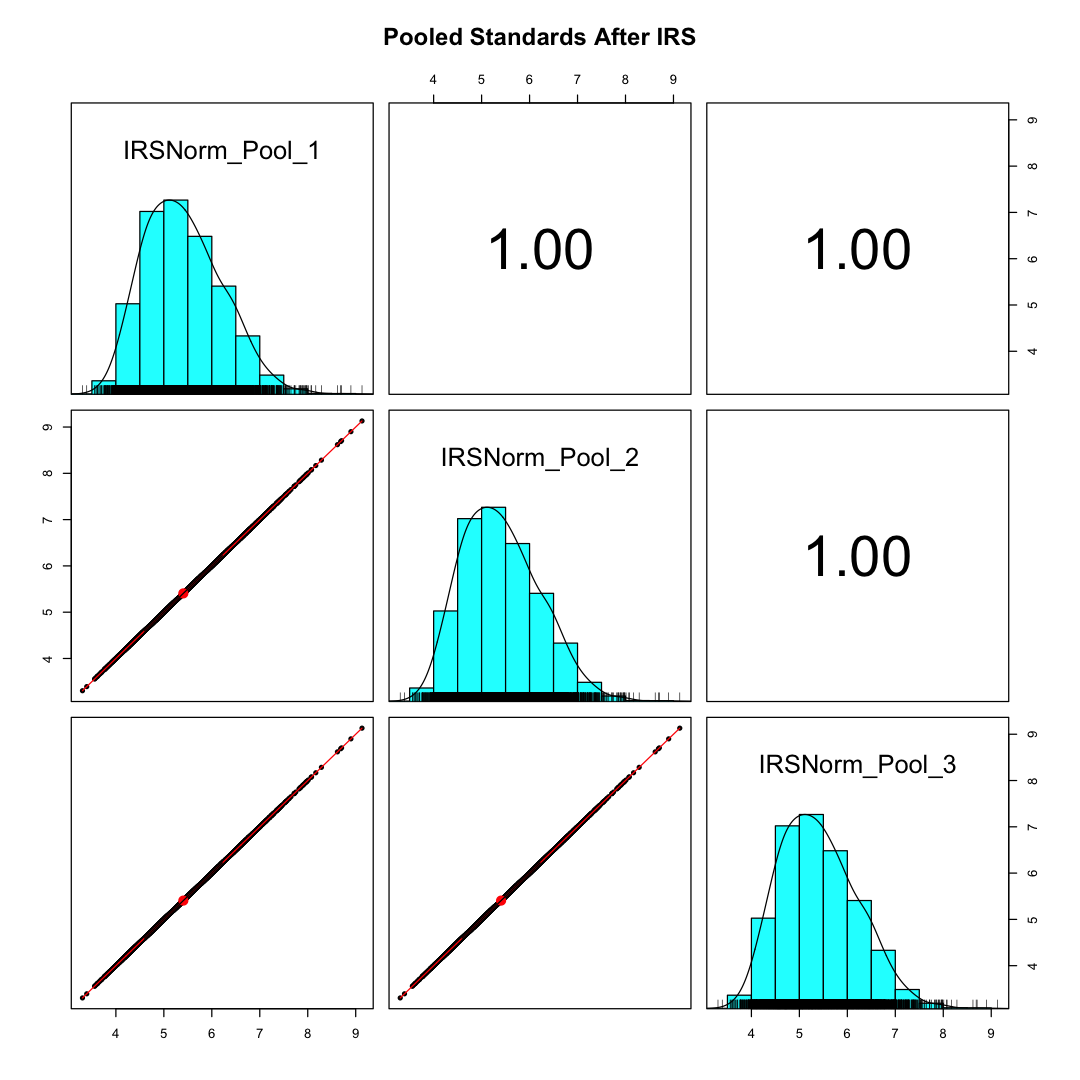

In [11]:
pairs.panels(log10(pools_after), main = "Pooled Standards After IRS")

### IRS method removes plex effects

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 IRSNorm_E15_1 -> 1.031476
 IRSNorm_E15_2 -> 1.008094
 IRSNorm_E15_3 -> 0.986400
 IRSNorm_E18_1 -> 1.010526
 IRSNorm_E18_2 -> 1.012694
 IRSNorm_E18_3 -> 0.997802
 IRSNorm_P0_1 -> 0.998726
 IRSNorm_P0_2 -> 0.991580
 IRSNorm_P0_3 -> 0.999595
 IRSNorm_P3_1 -> 0.986234
 IRSNorm_P3_2 -> 0.999611
 IRSNorm_P3_3 -> 1.005907
 IRSNorm_P6_1 -> 0.980859
 IRSNorm_P6_2 -> 0.993474
 IRSNorm_P6_3 -> 1.011724
 IRSNorm_P9_1 -> 0.974078
 IRSNorm_P9_2 -> 1.004781
 IRSNorm_P9_3 -> 1.009580

Trimmed mean of M-values (TMM) factors:
 IRSNorm_E15_1 -> 0.712297
 IRSNorm_E15_2 -> 0.660870
 IRSNorm_E15_3 -> 0.666675
 IRSNorm_E18_1 -> 0.839775
 IRSNorm_E18_2 -> 0.704975
 IRSNorm_E18_3 -> 0.849973
 IRSNorm_P0_1 -> 0.908618
 IRSNorm_P0_2 -> 0.896906
 IRSNorm_P0_3 -> 0.880678
 IRSNorm_P3_1 -> 1.077557
 IRSNorm_P3_2 -> 1.213998
 IRSNorm_P3_3 -> 1.069485
 IRSNorm_P6_1 -> 1.224558
 IRSNorm_P6_2 -> 1.314099
 IRSNorm_P6_3 -> 1.317240
 IRSNorm_P9_1 -> 1.463104
 IRSNorm_P9_2 -> 1.354746
 IRSNorm_P9_3 

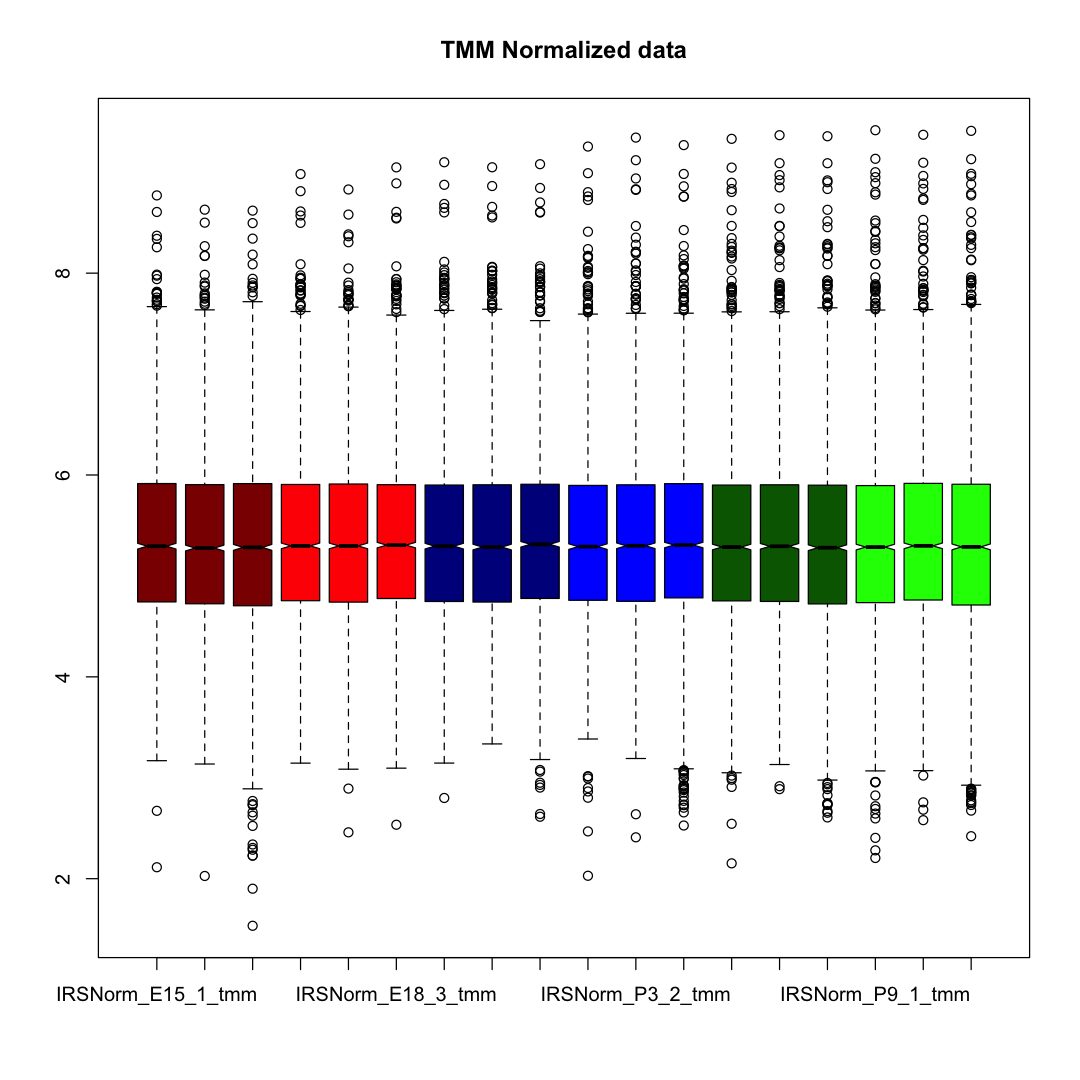

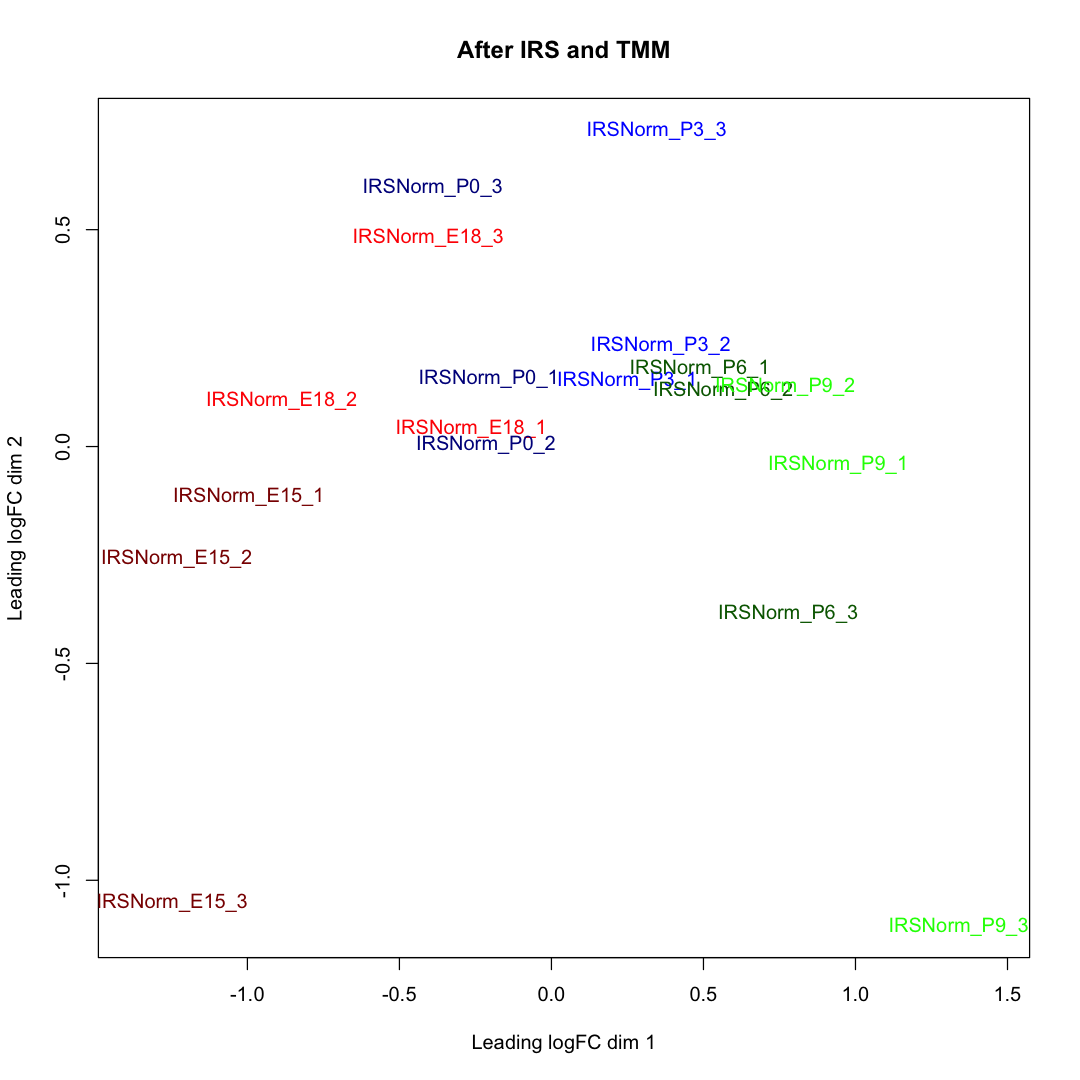

In [12]:
# get the biological sample data into a DGEList object
group = c(rep("E15", length(E15)), rep("E18", length(E18)), 
          rep("P0", length(P0)), rep("P3", length(P3)), 
          rep("P6", length(P6)), rep("P9", length(P9)))

y <- DGEList(counts = tmt_irs[1:18], group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors_group)

# check the clustering
plotMDS(y, col = colors_group, main = "After IRS and TMM")

### TMM factors increase with age

The developing lens has more and more crystallin content with increasing age. The epithelial cell and differentiating fiber cells have a richer proteome. Mature fiber cells are more dominated by crystallins and other lens-specific proteins. The bulk of the proteome proteins are progressively "pushed down" in relative abundance with increasing age. The TMM factors need to boost these proteins in abundance to have the median proteome intensities match across the ages. The boxplots are horizontally aligned. The abundant lens proteins are the dots above the top whiskers, and we see those increase with age.

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the biological conditions.

We have data at various stages of normalization corrections. The SLNorm step makes global aspects of the data similar (the column sums of reporter ion intensities). IRS is more complicated and does protein-by-protein corrections using the reference channels to "spy" on how our biological samples were sampled by the instrument. The reference channel intensity be the same for each protein in each plex. The factors that make that adjustment are applied to all the biological sample channels to bring both plexes onto a common measurement scale. The TMM normalization is finally applied to correct for any compositional differences between sample groups.

In [13]:
# put CVs in data frames to simplify plots and summaries
# we will skip the n=1 group (TOFPS)
cv_sl <- data.frame(E15 = CV(tmt_sl[E15]), E18 = CV(tmt_sl[E18]), 
                    P0 = CV(tmt_sl[P0]), P3 = CV(tmt_sl[P3]), 
                    P6 = CV(tmt_sl[P6]), P9 = CV(tmt_sl[P9]))
cv_irs <- data.frame(E15 = CV(tmt_irs[E15]), E18 = CV(tmt_irs[E18]),
                     P0 = CV(tmt_irs[P0]), P3 = CV(tmt_irs[P3]),
                     P6 = CV(tmt_irs[P6]), P9 = CV(tmt_irs[P9]))
cv_tmm <- data.frame(E15 = CV(tmt_tmm[E15]), E18 = CV(tmt_tmm[E18]),
                     P0 = CV(tmt_tmm[P0]), P3 = CV(tmt_tmm[P3]),
                     P6 = CV(tmt_tmm[P6]), P9 = CV(tmt_tmm[P9]))

# see what the median CV values are
medians <- apply(cv_sl, 2, FUN = median)
print("SLNorm median CVs by condition (%)")
round(medians, 2)

medians <- apply(cv_irs, 2, FUN = median)
print("IRSNorm median CVs by condition (%)")
round(medians, 2)

medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "SLNorm median CVs by condition (%)"


E15   E18    P0    P3    P6    P9 
52.76 56.49 51.02 53.04 54.50 56.08

[1] "IRSNorm median CVs by condition (%)"


E15   E18    P0    P3    P6    P9 
15.34 17.96 11.74 14.94 13.39 15.49

[1] "Final median CVs by condition (%)"


E15   E18    P0    P3    P6    P9 
14.08 15.28 11.68 13.39 12.69 15.47

### The median CVs are improved by normalizations

Normalization|Average Median CV
---|---
Starting data|53.9%
IRS only|14.7%
IRS + TMM|13.8%

Starting median CVs are in the mid 50% range (plex-to-plex variability is high without IRS). After IRS, median CVs are around 15% and drop to about 14% after TMM. Real human samples have sample-to-sample variability and median CVs of about 20% are common. Animal models might be low teens to higher single digits. Cell cultures are mostly less than 10%. Technical replicates can get towards 3% median CVs.

### Use ggplot to visualize the CV distributions

We will just compare the SLNorm starting data to the final TMM normalized data here.

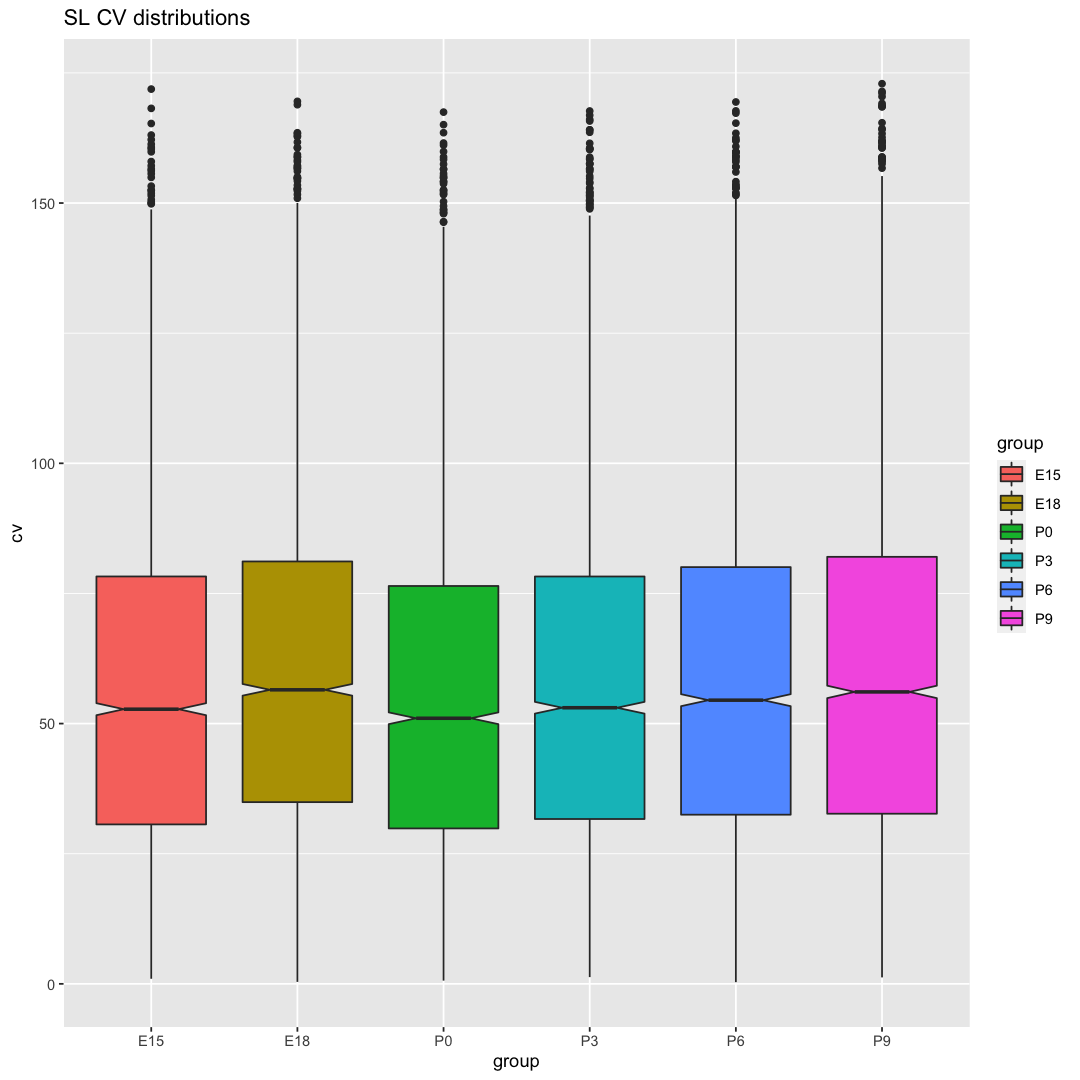

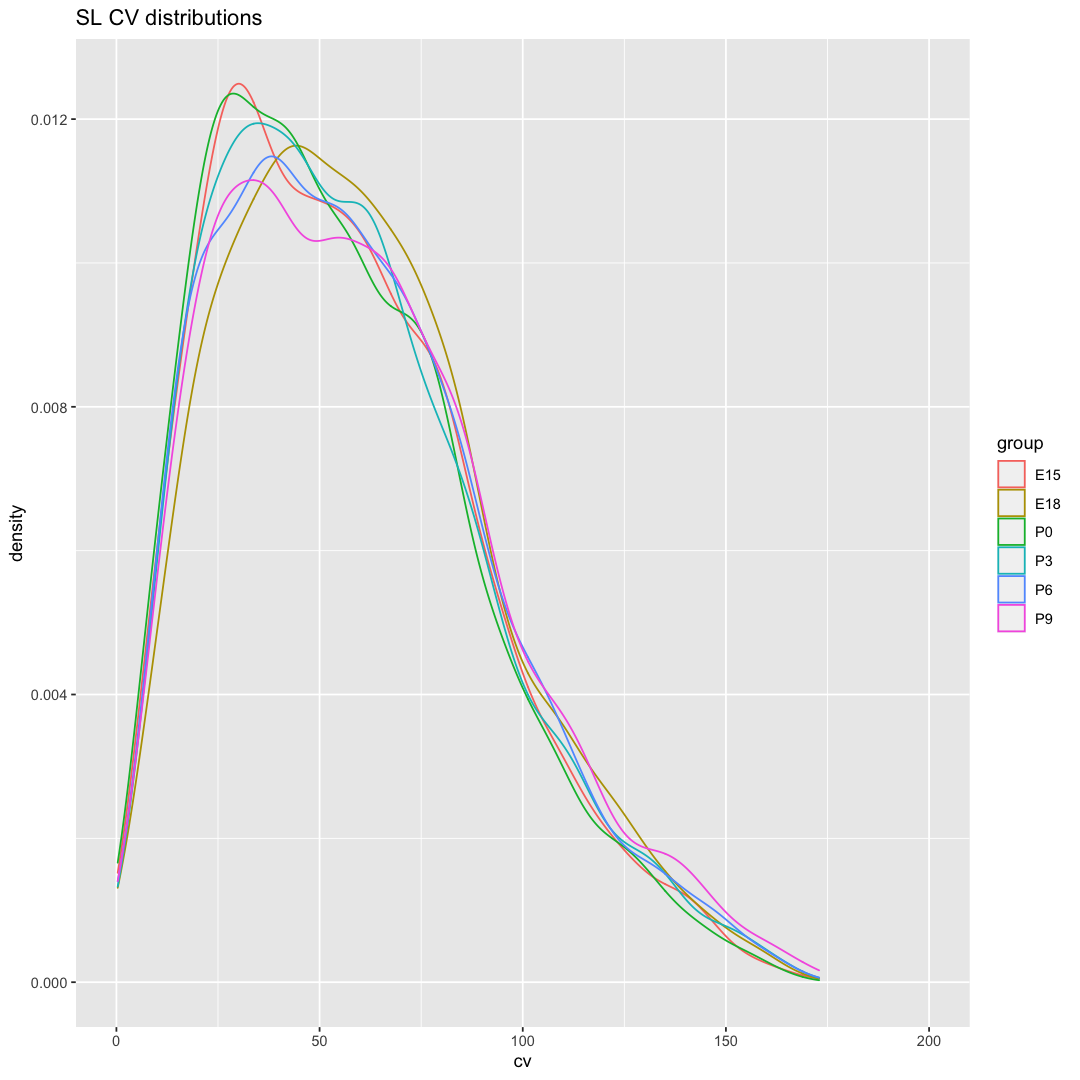

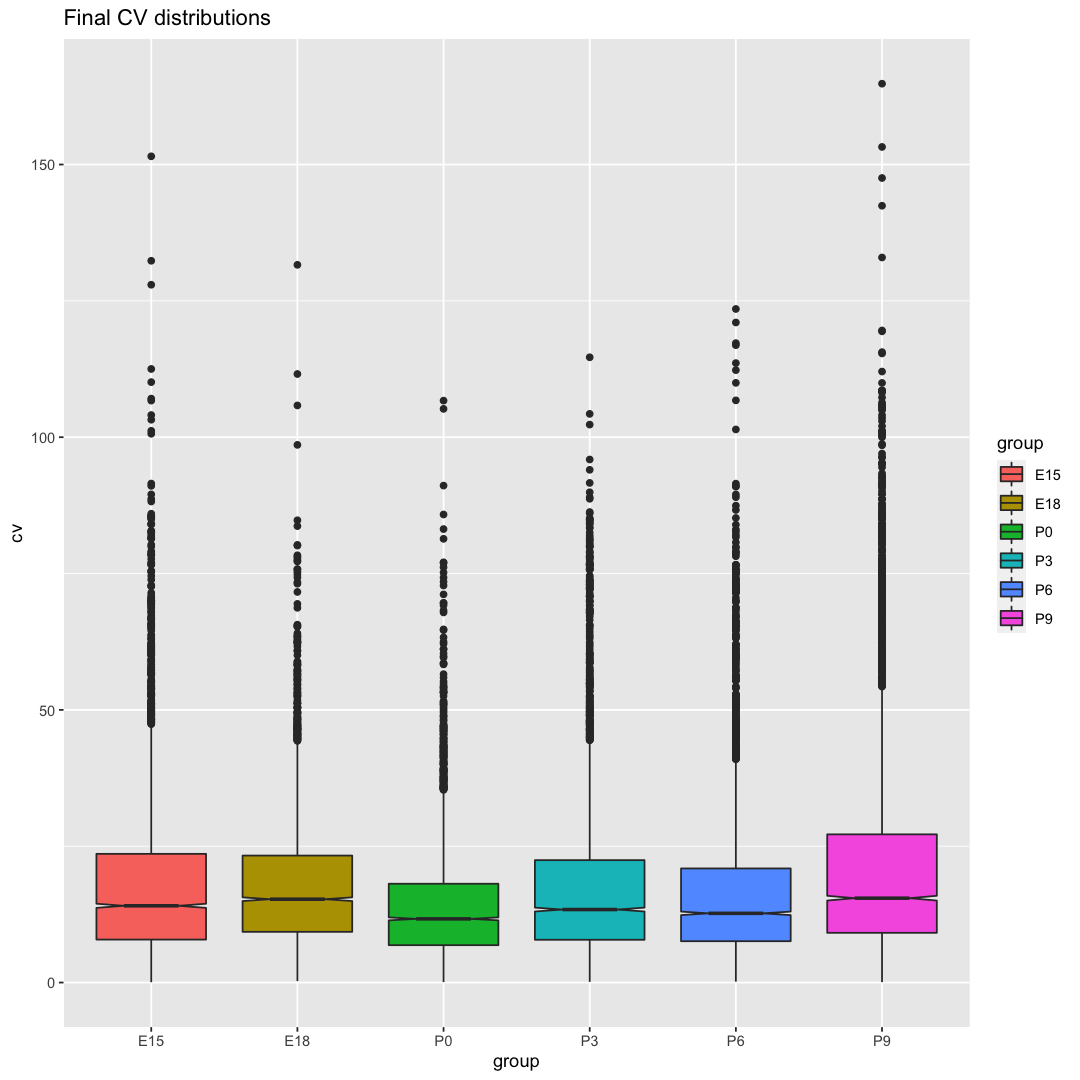

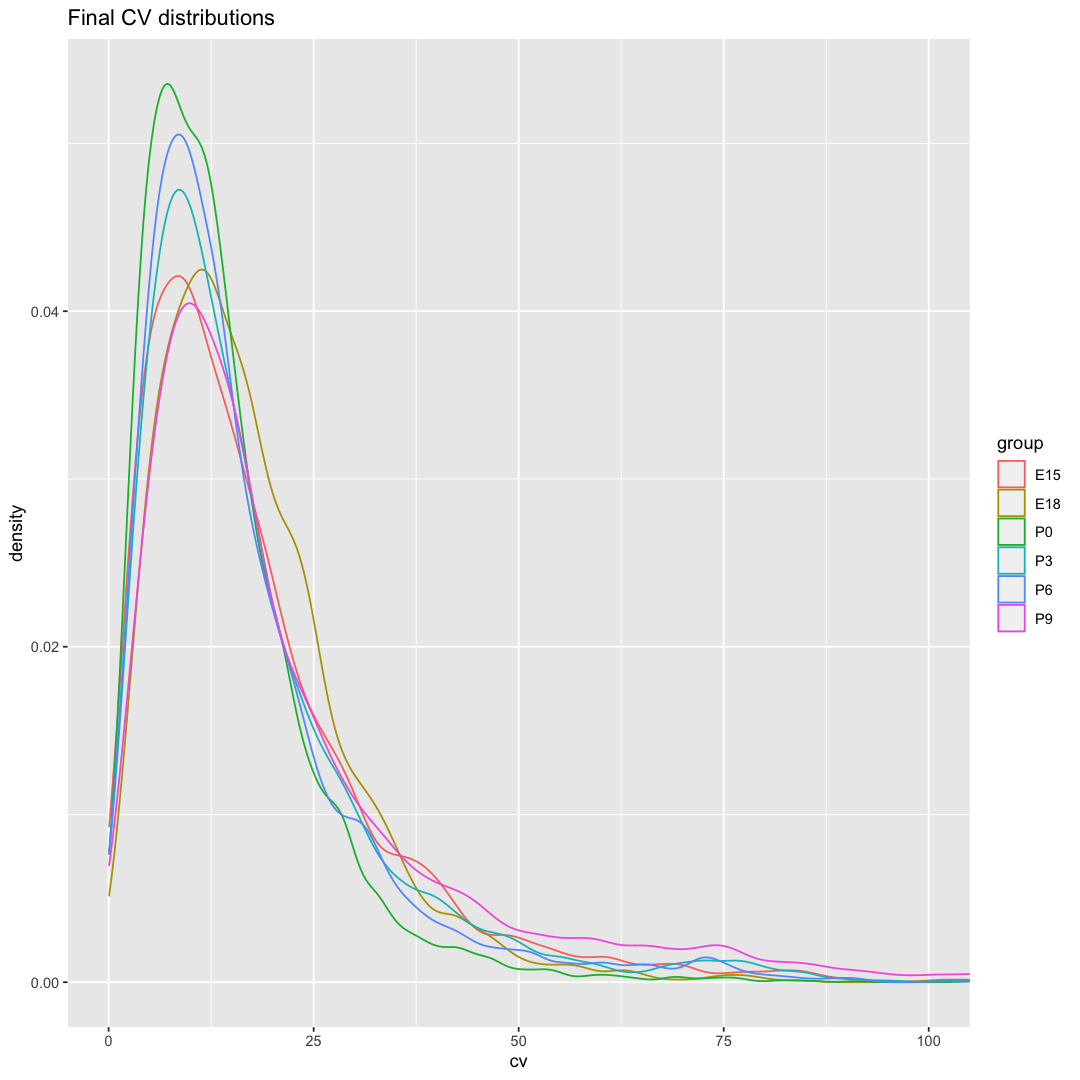

In [14]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_sl <- gather(cv_sl, key = "group", value = "cv")

# traditional boxplots
ggplot(long_cv_sl, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("SL CV distributions")

# density plots
ggplot(long_cv_sl, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 200)) +
  ggtitle("SL CV distributions")

# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("Final CV distributions")

### CV distributions are improved by IRS + TMM

## <a name="scatter_plots"></a>Finally, compare samples within each biological condition

We can also look at each biological condition with a multi-panel scatter plot grid and see how similar the replicates are to each other. We can look at the intensities before IRS and after IRS with TMM (final data).

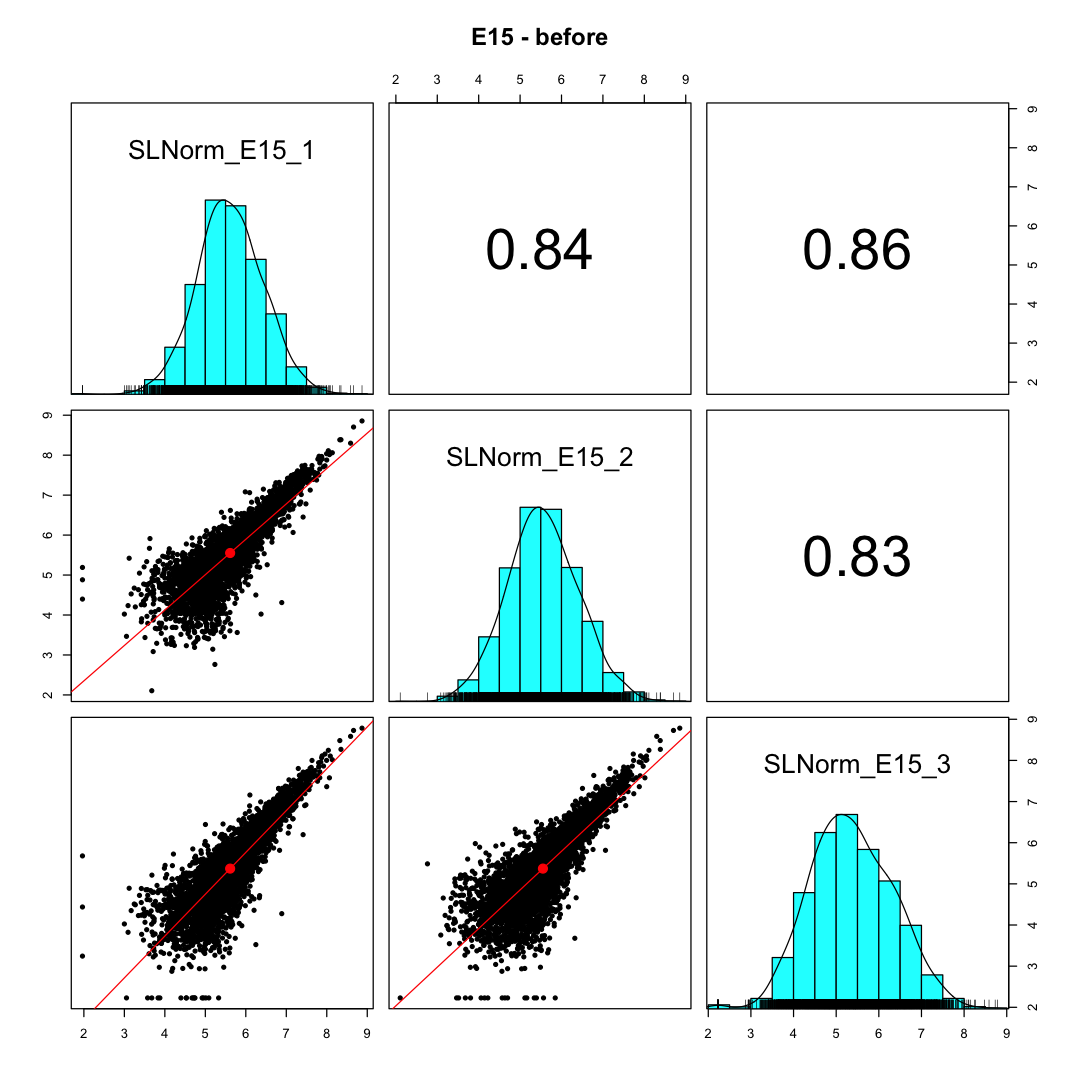

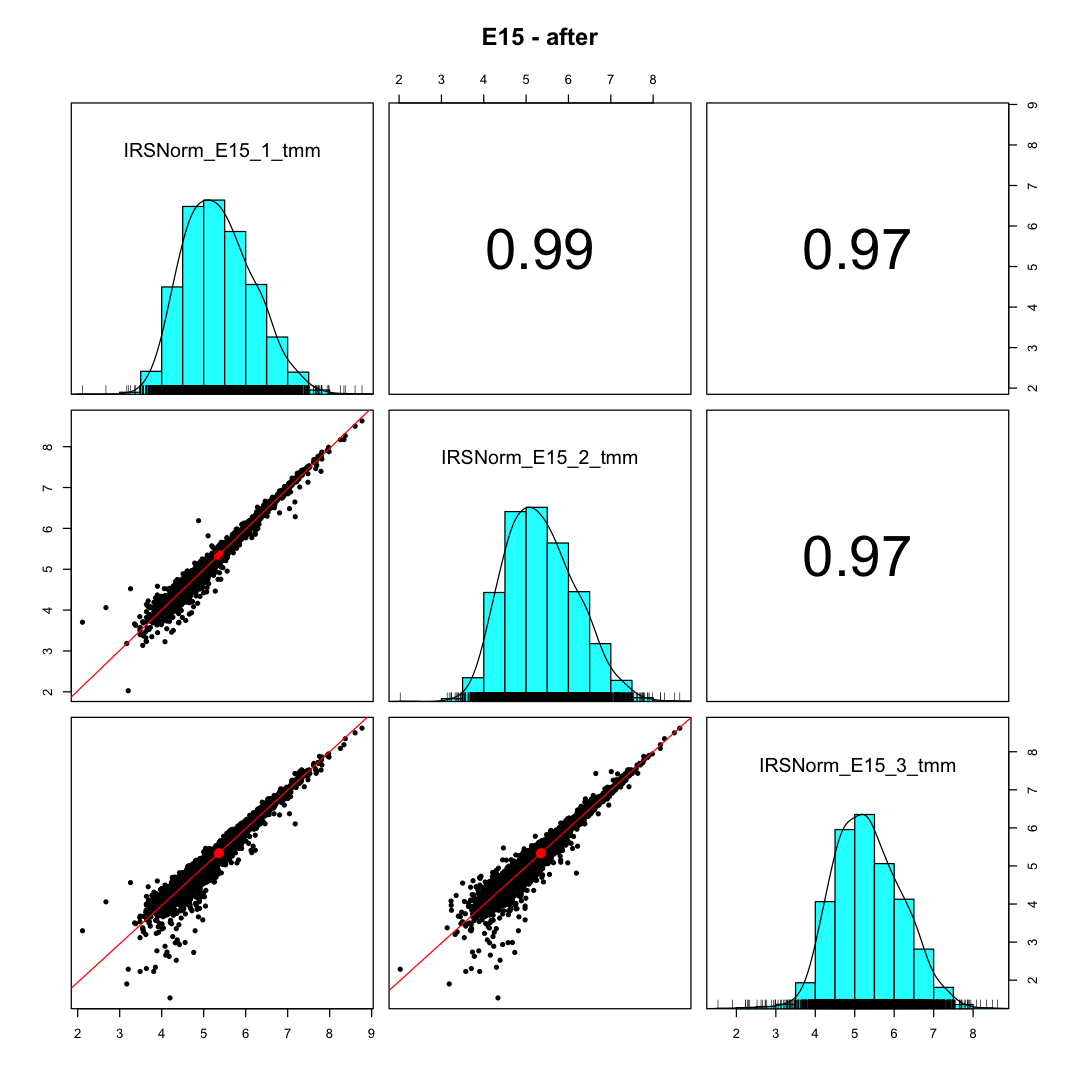

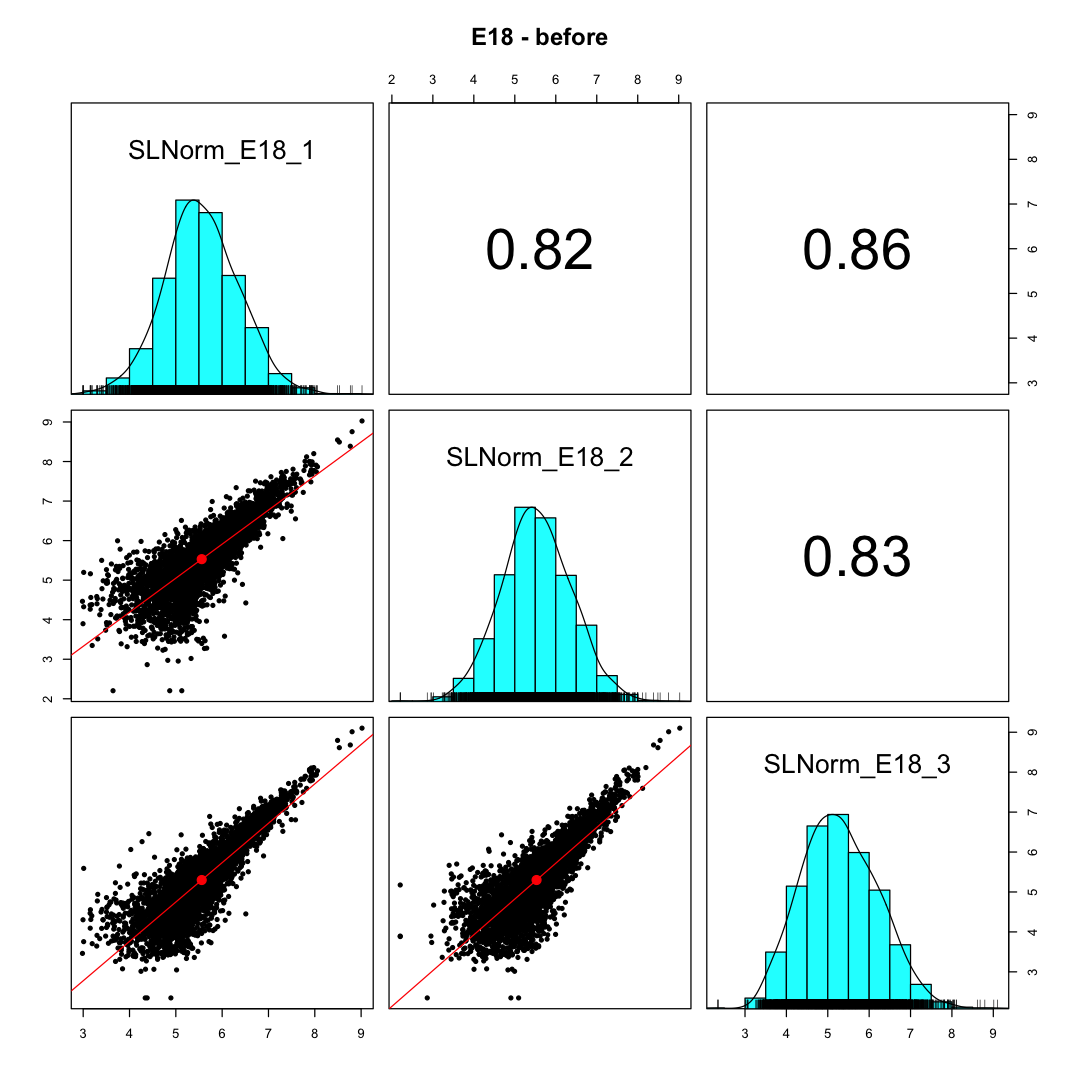

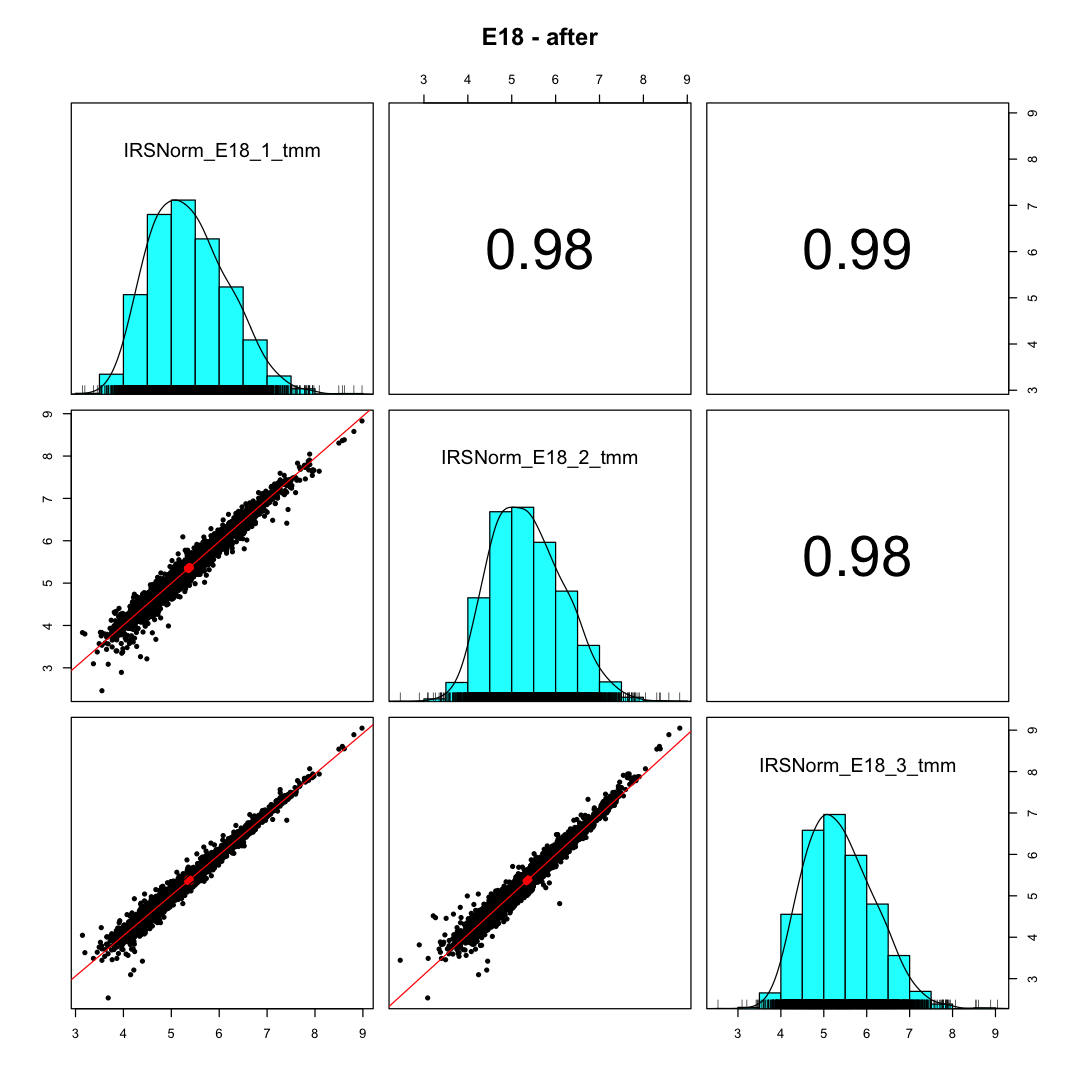

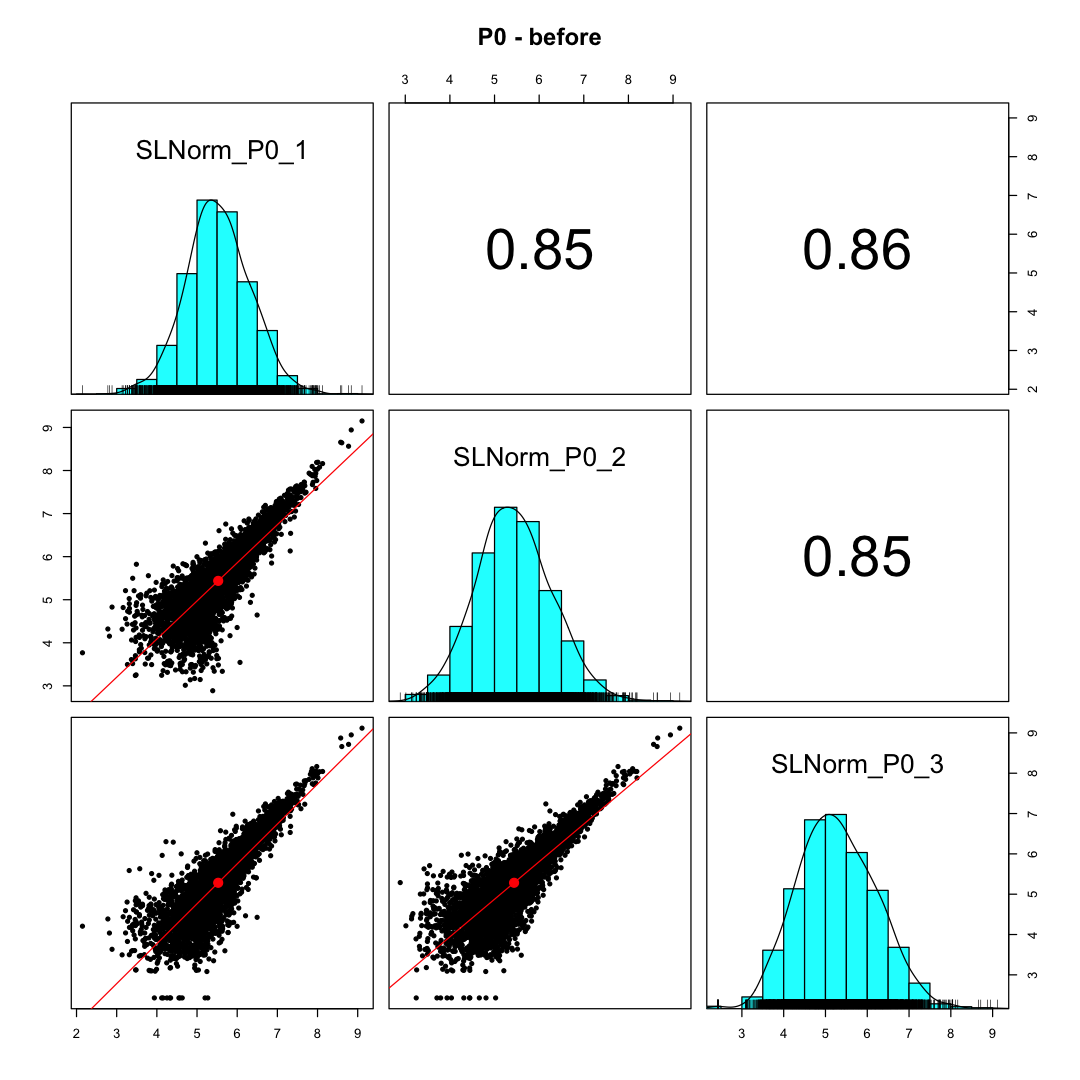

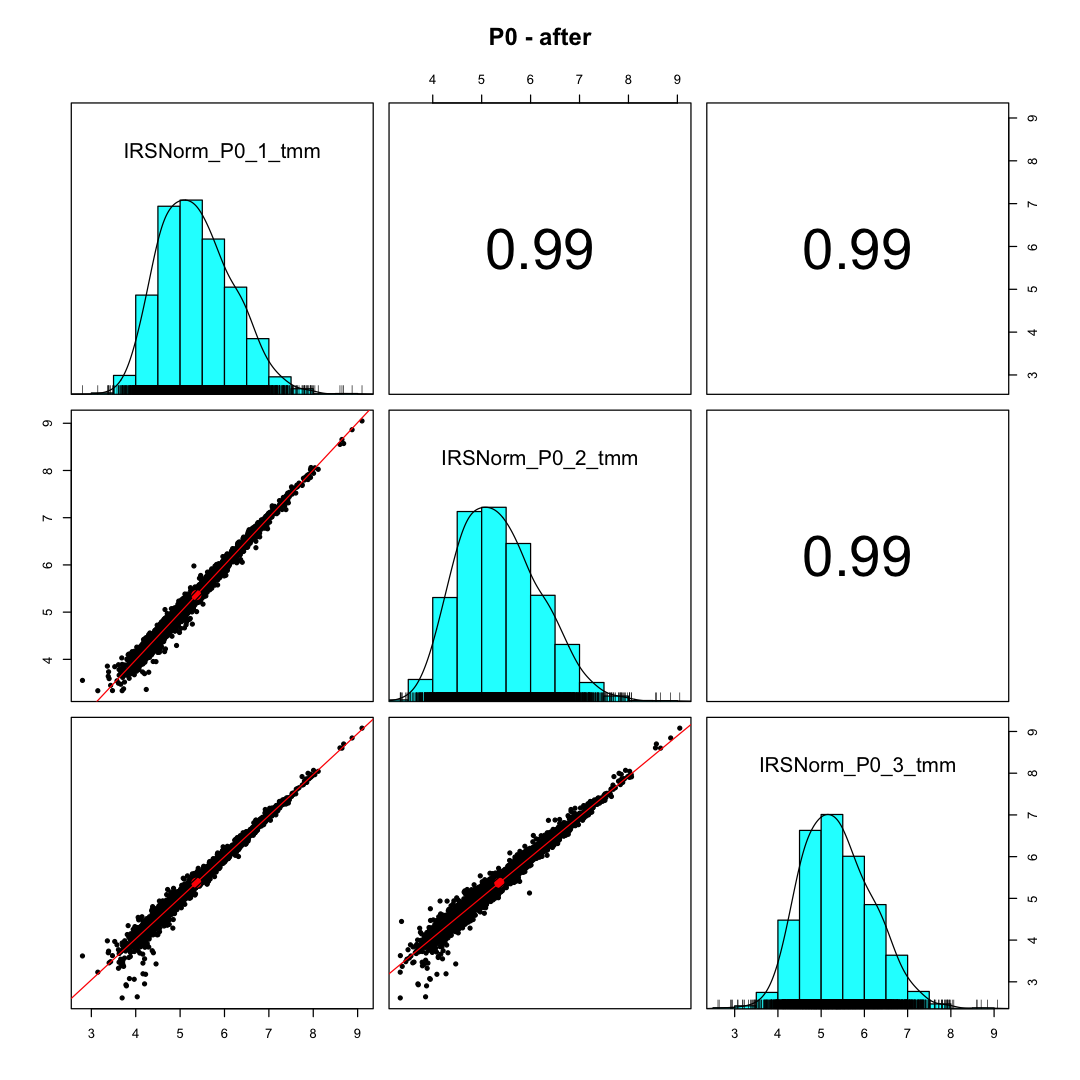

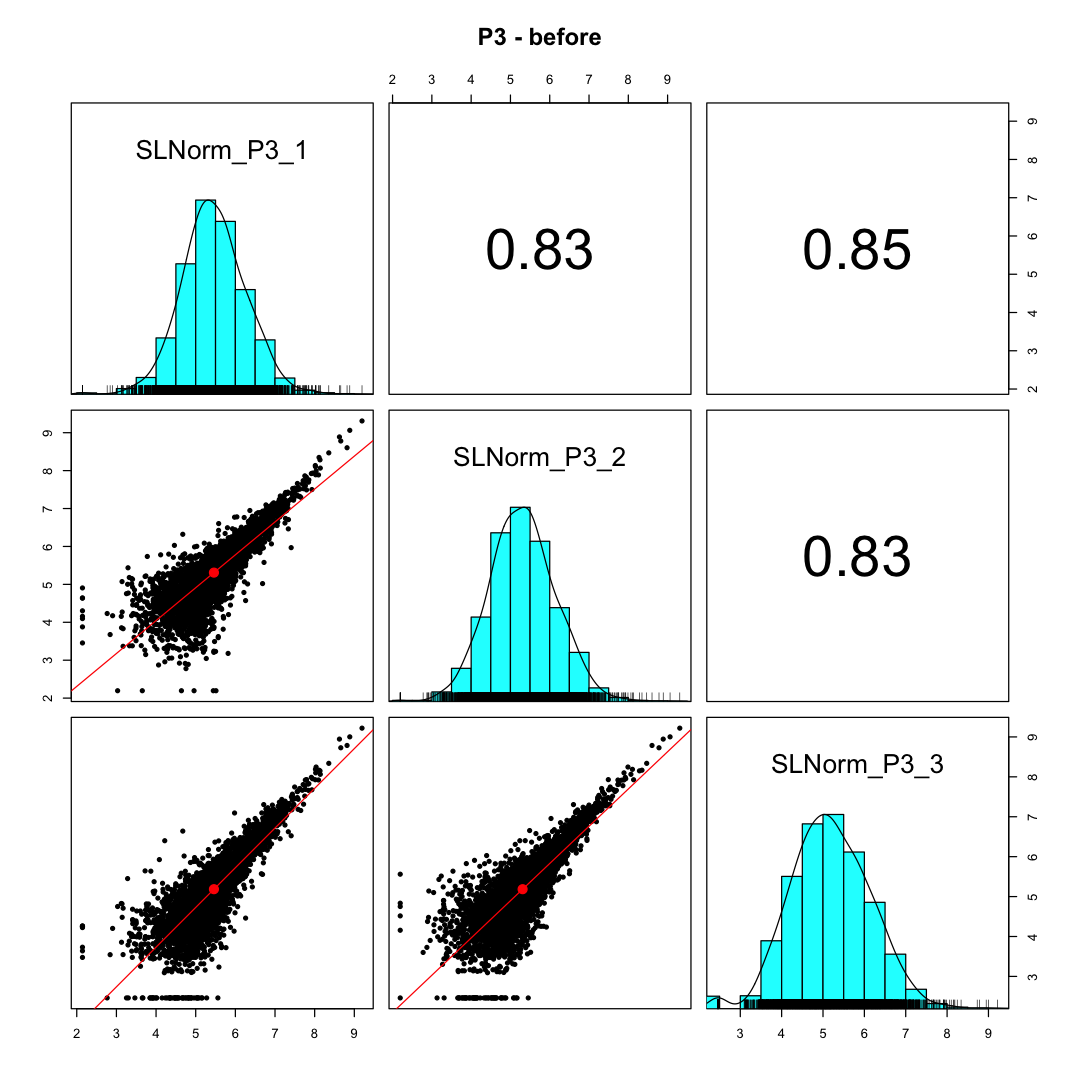

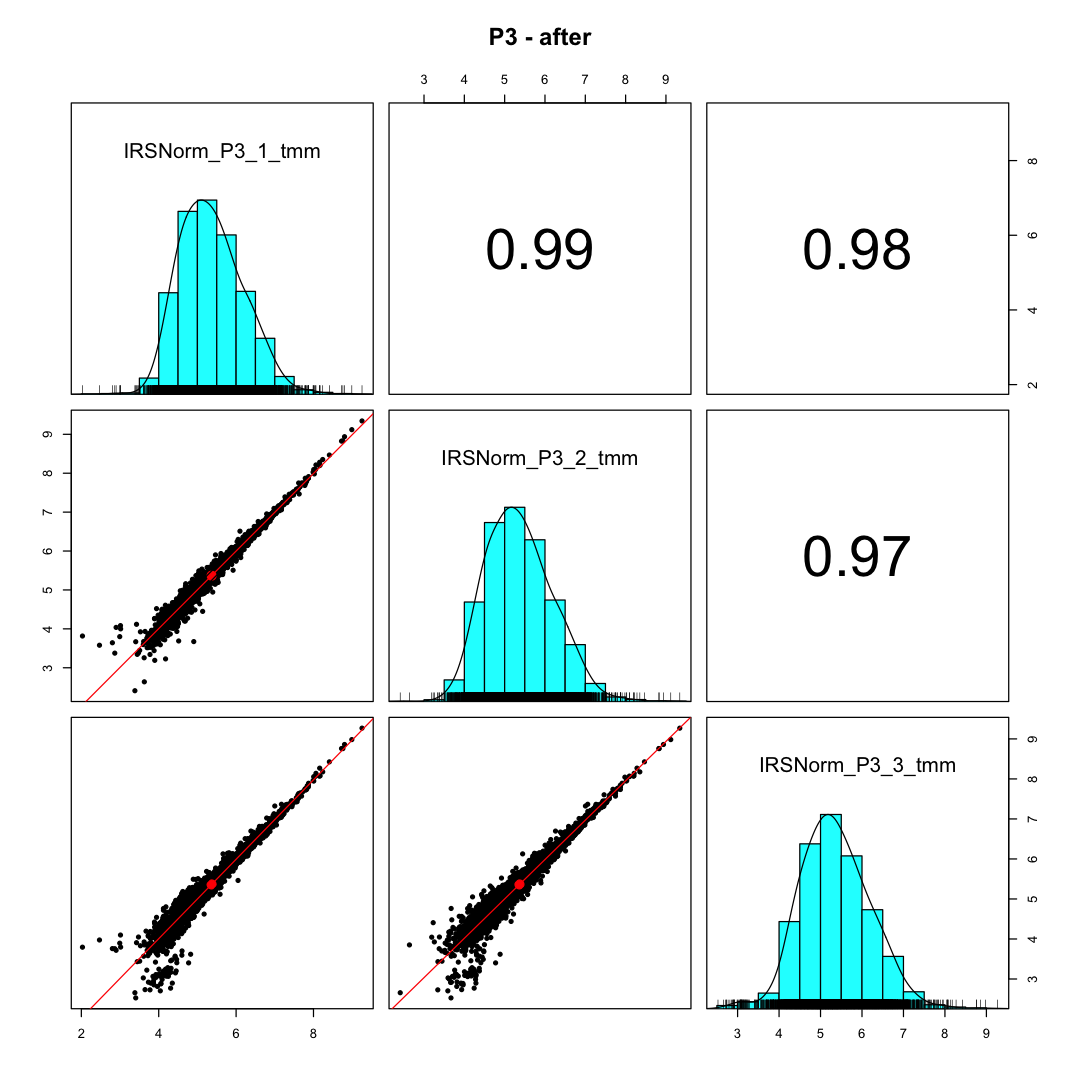

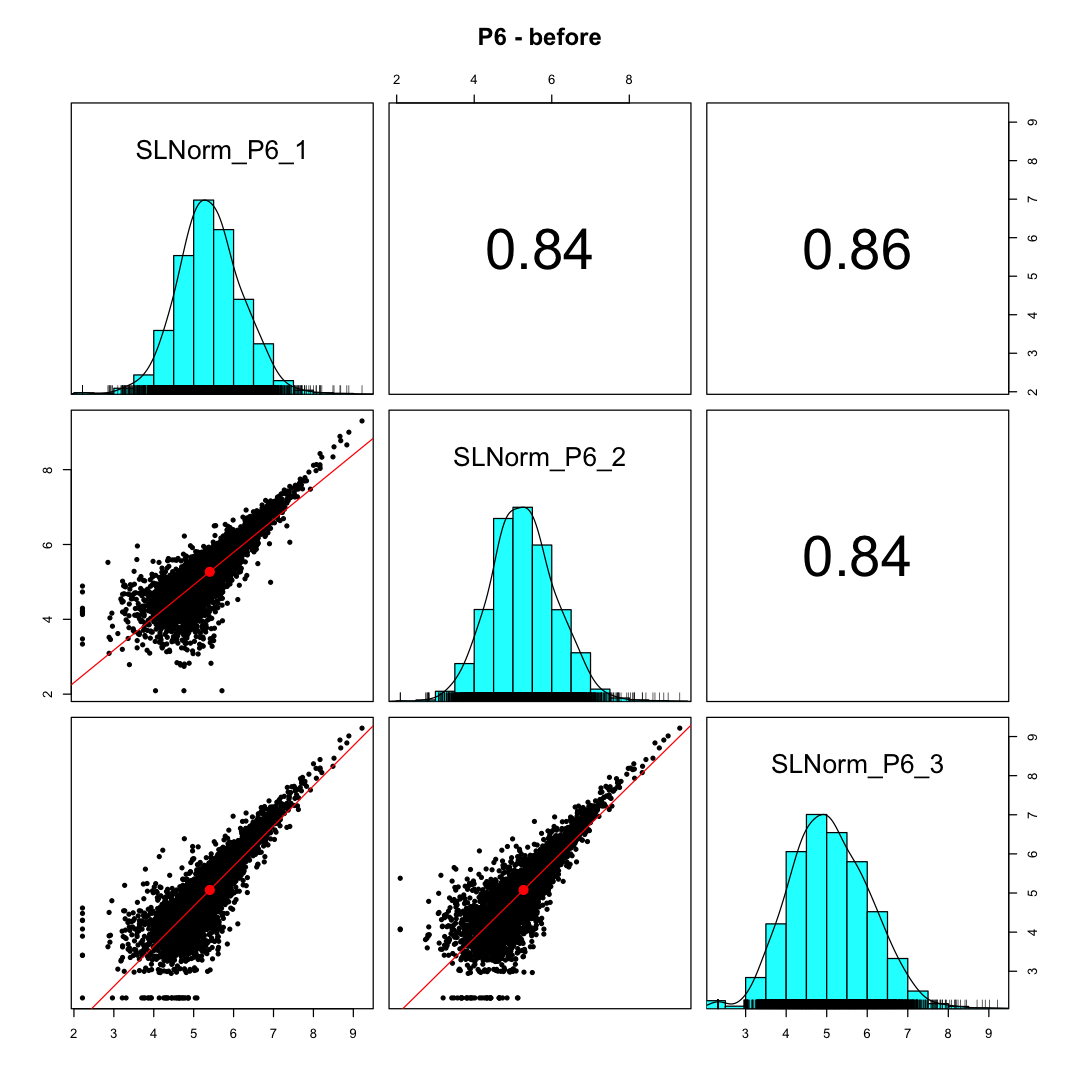

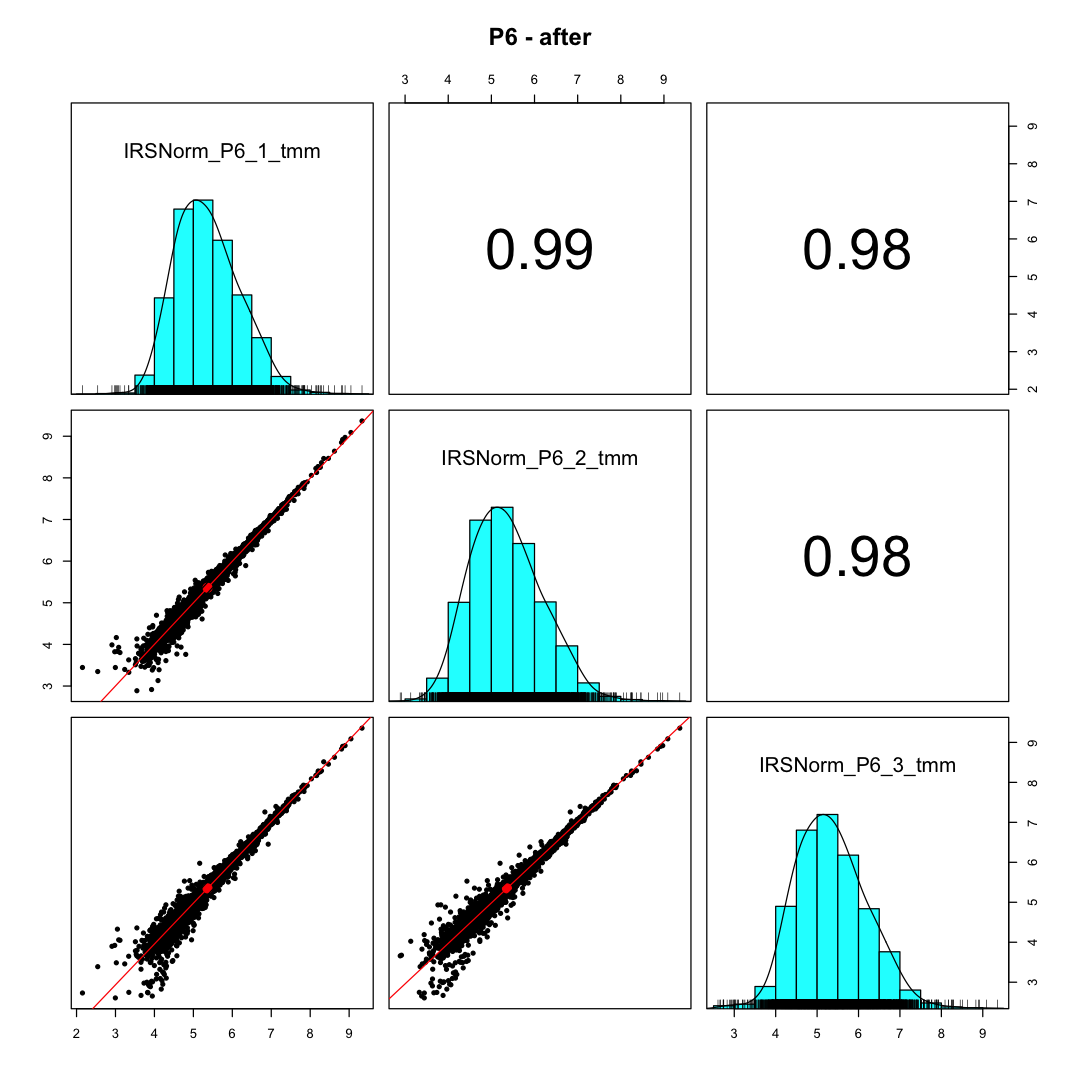

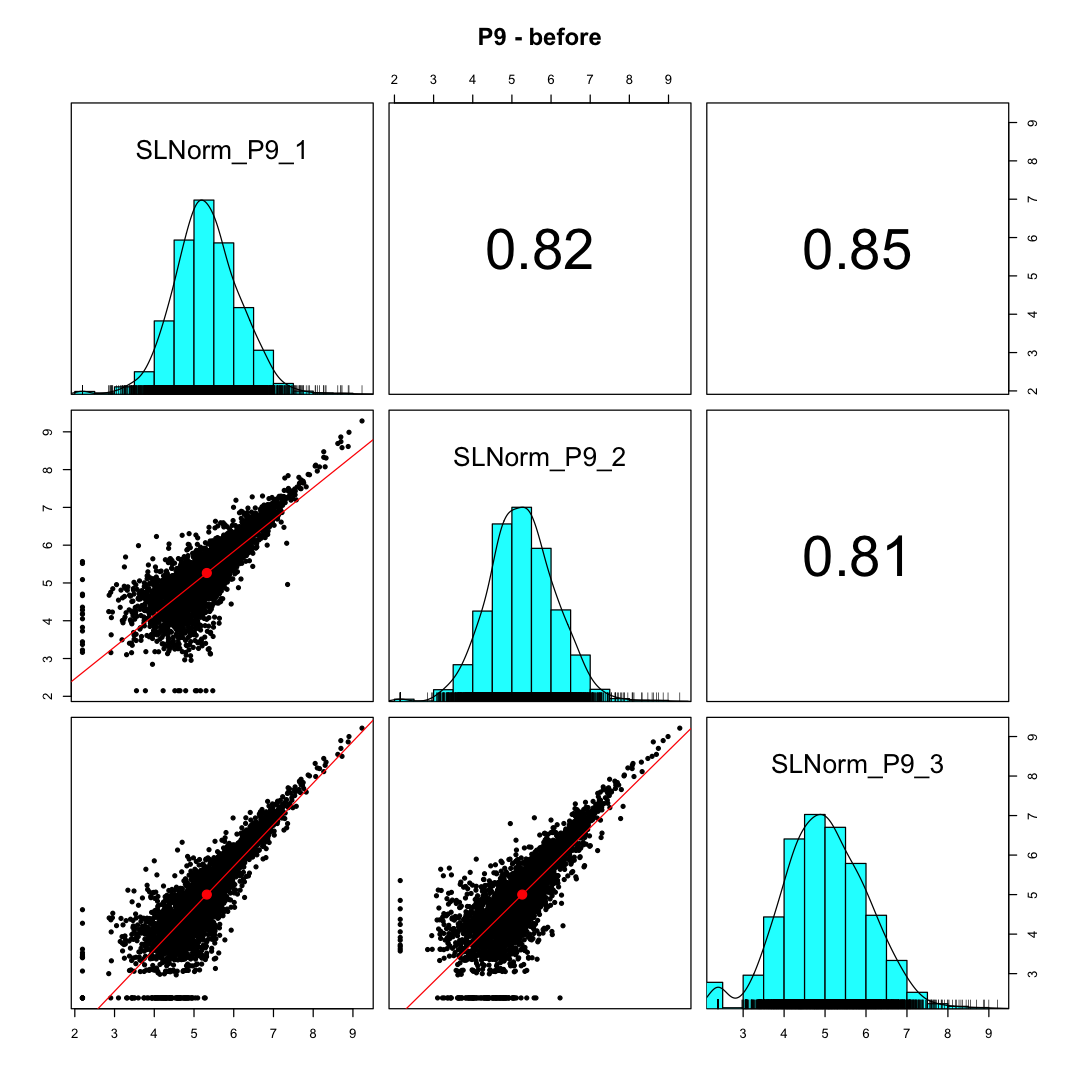

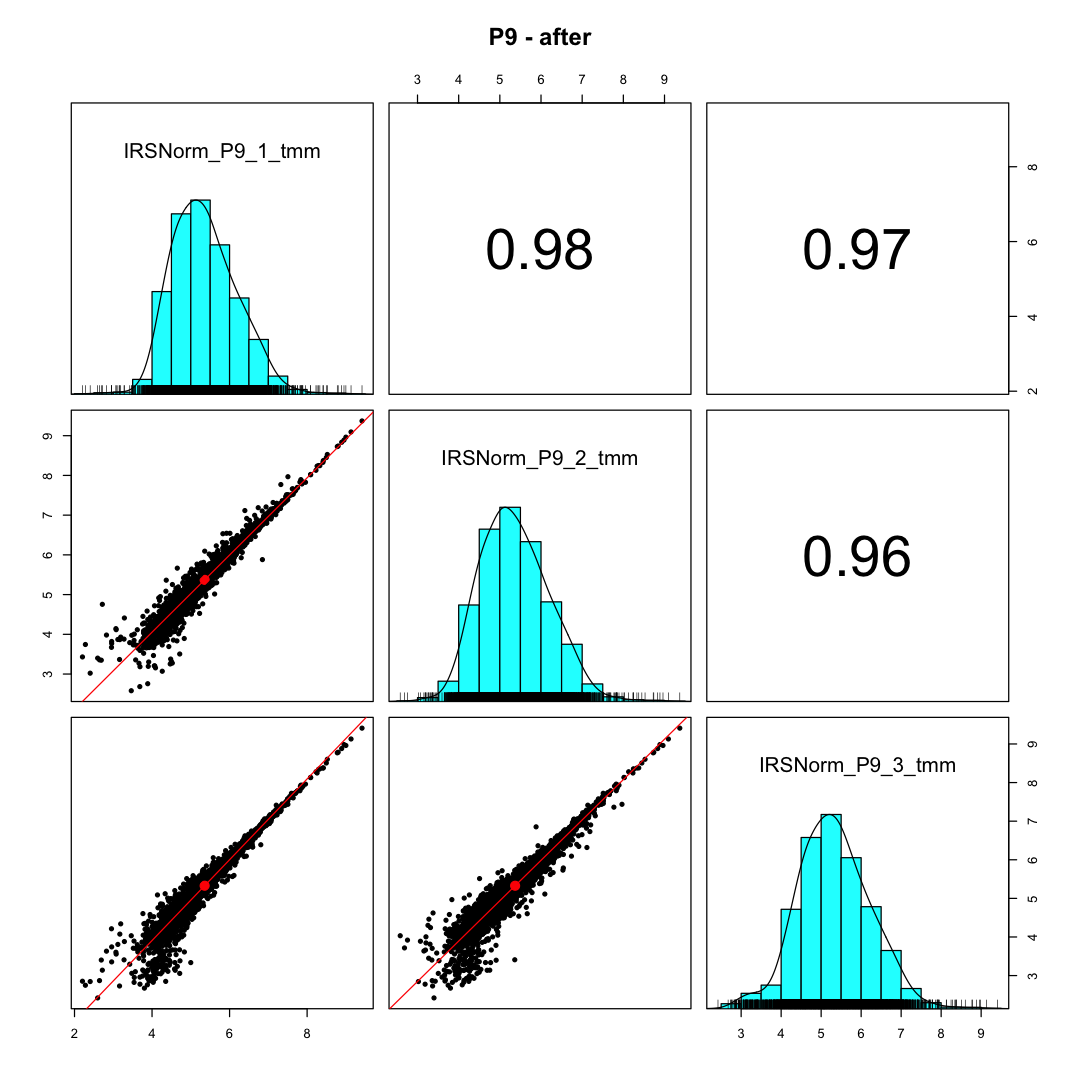

In [15]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(tmt_sl[E15]), lm = TRUE, main = "E15 - before")
pairs.panels(log10(tmt_tmm[E15]), lm = TRUE, main = "E15 - after")

pairs.panels(log10(tmt_sl[E18]), lm = TRUE, main = "E18 - before")
pairs.panels(log10(tmt_tmm[E18]), lm = TRUE, main = "E18 - after")

pairs.panels(log10(tmt_sl[P0]), lm = TRUE, main = "P0 - before")
pairs.panels(log10(tmt_tmm[P0]), lm = TRUE, main = "P0 - after")

pairs.panels(log10(tmt_sl[P3]), lm = TRUE, main = "P3 - before")
pairs.panels(log10(tmt_tmm[P3]), lm = TRUE, main = "P3 - after")

pairs.panels(log10(tmt_sl[P6]), lm = TRUE, main = "P6 - before")
pairs.panels(log10(tmt_tmm[P6]), lm = TRUE, main = "P6 - after")

pairs.panels(log10(tmt_sl[P9]), lm = TRUE, main = "P9 - before")
pairs.panels(log10(tmt_tmm[P9]), lm = TRUE, main = "P9 - after")

### Sample-to-sample correlations are improved after IRS

We knew from the median CVs that sample-to-sample scatter plots will not be super tight to the diagonal trend lines. They are much broader before IRS and are reasonable after IRS. The data seem fine to move onto the statistical testing steps.

### Compare averages of each group to each other

We can get a little heads up on the statistical testing by comparing group averages to each other. We will compare boxplots of the data after IRS only and after IRS + TMM adjustments to get a sense of how different normalization assumptions affect the final data. We will also make a scatter plot grid to see age-related trends.

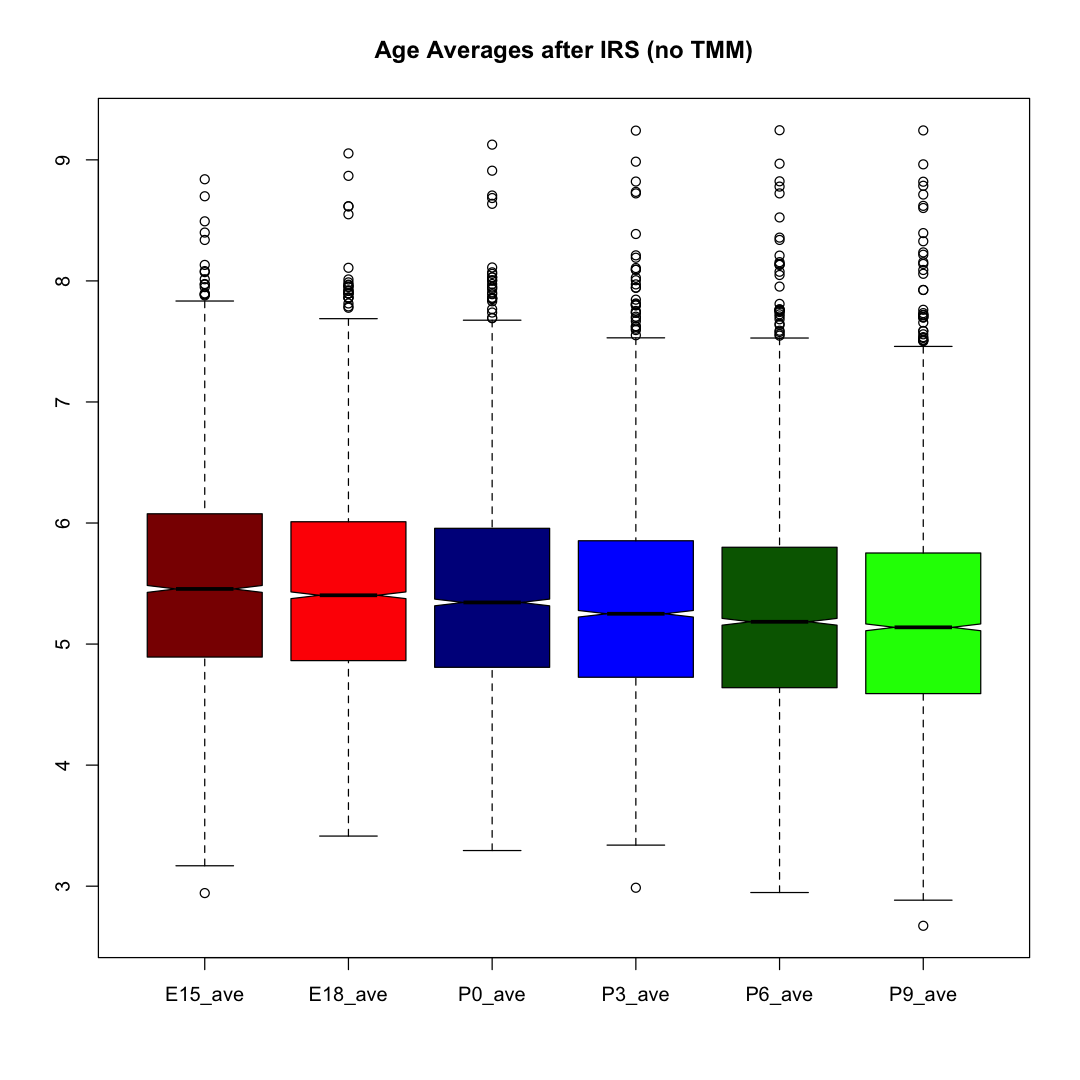

In [16]:
# save the dataframe with the averages by developmental age
age_ave_irs <- cbind(E15_ave = rowMeans(tmt_irs[E15]),
                     E18_ave = rowMeans(tmt_irs[E18]),
                     P0_ave = rowMeans(tmt_irs[P0]),
                     P3_ave = rowMeans(tmt_irs[P3]),
                     P6_ave = rowMeans(tmt_irs[P6]),
                     P9_ave = rowMeans(tmt_irs[P9]))

age_ave_tmm <- cbind(E15_ave = rowMeans(tmt_tmm[E15]),
                     E18_ave = rowMeans(tmt_tmm[E18]),
                     P0_ave = rowMeans(tmt_tmm[P0]),
                     P3_ave = rowMeans(tmt_tmm[P3]),
                     P6_ave = rowMeans(tmt_tmm[P6]),
                     P9_ave = rowMeans(tmt_tmm[P9]))

# make boxplot of age averages after IRS without TMM
colors_ave = c('dark red', 'red', 'dark blue', 'blue', 'dark green', 'green')
boxplot(log10(age_ave_irs), 
        col = colors_ave, 
        notch = TRUE, 
        main = "Age Averages after IRS (no TMM)")

### Total intensity matching does not horizontally align distributions.

We have proteome compositional changes with developmental age. High abundance proteins (open circles above the top whiskers) increase in relative abundance with age and push the distribution of other proteins down in intensity (medians, inter-quartile ranges sag left-to-right).

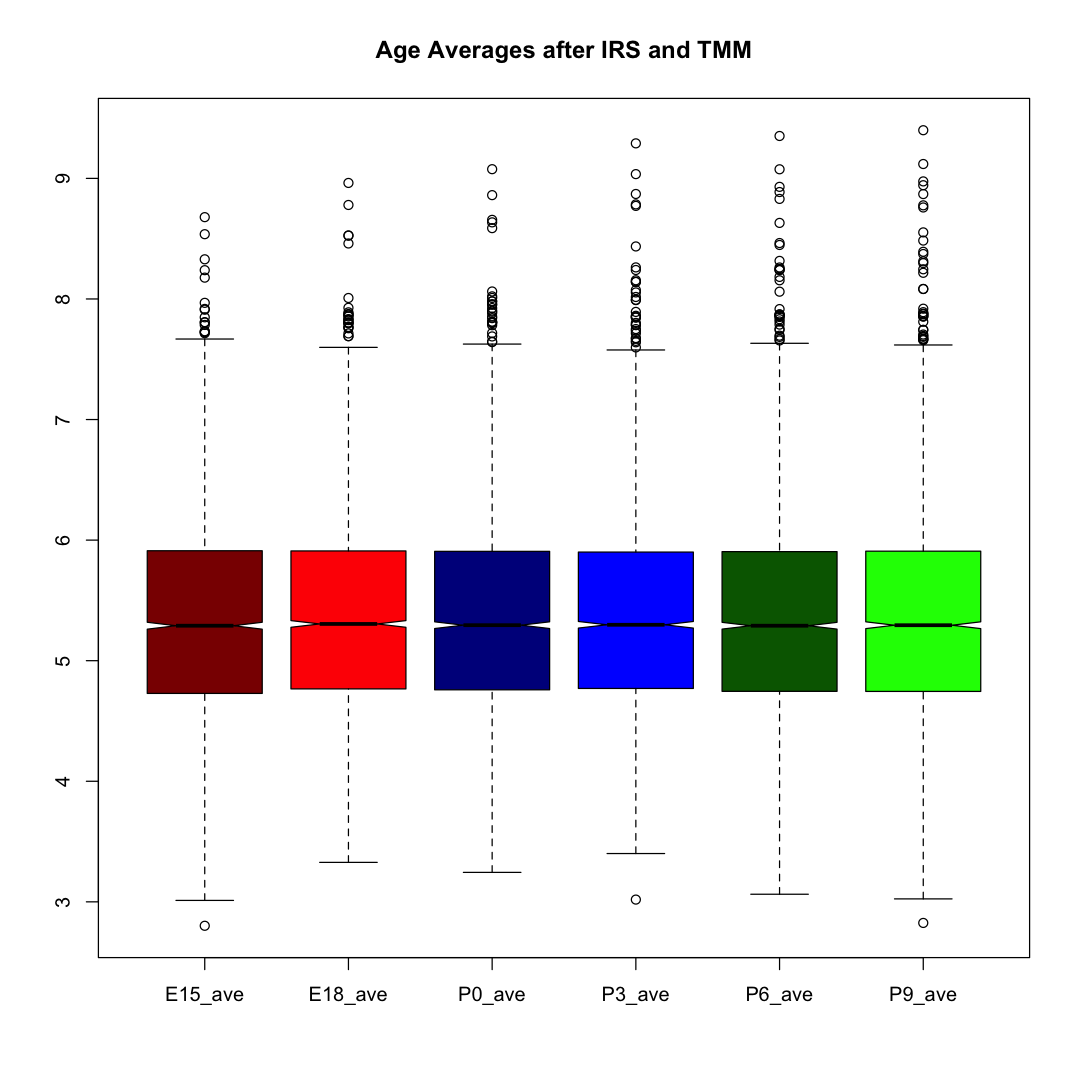

In [17]:
# make boxplot of age averages with both IRS and TMM
boxplot(log10(age_ave_tmm), 
        col = colors_ave, 
        notch = TRUE, 
        main = "Age Averages after IRS and TMM")

### TMM improves horizontal alignment of distributions

The medians (notches), inter-quartile ranges (boxes), and top whiskers are all in excellent horizontal alignment after TMM. The high abundance proteins (open circles above the top whiskers) now increase with developmental age. 

## Why we need TMM even after IRS

It may seem that there are too many normalization steps (three) being used on TMT data. Each step is doing something different to correct for different measurement deficiencies. The digestion, labeling, and mixing steps are all designed to have equal amounts of each sample. Protein assays are done on samples before digestion so that the same total amount of protein is digested. Peptide assays may be done after digestion to verify that there are equal amounts of peptides from each sample are labeled. Different volumes of samples are used in these bench steps to **normalize** between samples. 

The sum of the reporter ion intensities in each channel is a proxy for the total amount of protein in each sample. After we mix the samples (the multiplexing) and generate the mass spec measurements, we should theoretically have equal total intensities per channel within each plex. That never seems to be the case in practice. That is why there is a grand total intensity matching normalization that is done before any other normalizations. The SL-normalization (sample loading) just makes the data match the bench steps. The SL-normalization factors are global (one factor per channel) scaling factors that are the same for all proteins in the respective channel. 

When there are multiple plexes, the general intensity scales between plexes may be quite different. Since individual channels per plex are adjusted to have the same grand total intensities (I use the average grand total intensity value as the target value for each sample's intensity grand total), it is easy with multiple plexes to make the target grand total intensity value be the experiment-wide average grand total. With the table from the IRS script, the starting data has already been normalized so that the grand total intensities per channel are the same across all plexes (3 plexes here). The "starting data" is not the raw data.

IRS does adjustments at the protein level. If there are 5,000 proteins in the results table, collectively there will be 5,000 adjustment factors, one for each protein in each plex. The same factor adjusts all the biological samples in each plex. The relative intensity differences between channels in each plex is conserved. The intensities for each protein in each plex are adjusted to a common intensity scale. After IRS, 3 plexes with 6 channels each become one plex with 18 channels. In a proper IRS experimental design, common pooled channels present in each plex are used to compute the adjustment factors so that the biological sample data remain mathematically independent from the adjustment data. Here, where we used the plex average intensities as mock reference channels, there is some dependence between the IRS factors and the final data values. 

IRS is a very specific data adjustment. It removes the pseudo random instrument sampling of eluting peptide ions. It is not a general-purpose normalization technique. It is more like a batch-correction method. TMT data after IRS has the same data characteristics as any TMT data. Although global scaling factors are used to put all plexes on a more similar intensity scale as part of the IRS procedure, matching intensity total between samples may not be the correct normalization for the data. 

Many types of samples can have smaller numbers of highly abundant proteins and larger numbers of less abundant proteins (serum/plasma, saliva, tears, muscle, and lens proteins to name a few). When grand totals are matched, it creates a constrained system that behaves like a funny pan balance with a fixed weight on one side and two pans on the other side. The highly abundant proteins are on one pan and the rest of the proteins are on the other pan. If you add or subtract weight from the highly abundant protein pan, you have to compensate by subtracting or adding weight to the rest of the proteins pan to keep the beam balanced against the fixed weight.

RNA-seq data has a similar problem where total number of reads per sample are often matched as a first data adjustment. If samples have some high abundance genes that change, this can distort all the rest of the genes in constrained grand totals. Instead of a few high abundance genes differing in abundance, the constrained total makes the high abundance data more similar and creates the illusion that larger number of less abundant gene changed expression (false negatives for the high abundance genes and false positives for the lower abundance genes). The [trimmed mean of M-values](https://link.springer.com/content/pdf/10.1186/gb-2010-11-3-r25.pdf) normalization method was developed to address normalization in genomic datasets. It is basically a median matching method (rather than a grand total matching) that is made more robust by the data trimming (high and low abundance data is dropped, large and small fold change data are dropped). What remains after trimming is a better set of values for the median determination.

## Which normalization is "better"?

Mathematically, either normalization approach is valid. The numbers of statistically significant proteins may be quite different in the two sets of normalized data because they end up having different definitions of proteins that are "the same" between samples. Basic hypothesis testing is computing the probability that proteins are "the same" between samples and trying to find proteins that are highly unlikely to be the same (the differential candidates). When we make different characteristics of the data "the same", we directly affect the null hypothesis in statistical testing.

This does not make one normalization method correct and the other incorrect. There are just different data that will produce different results and that will require different thinking for correct interpretation. However, one normalization method may produce data and results that are more intuitive for interpretation. Matching the intensity grand totals between samples preserves the constrained nature of the proteomes. Constrained systems are not very intuitive. Despite the considerable time we spend engaged in circular logic, we are not very good thinking about circles. This is the main criticism of pie charts - we do not estimate the relative sizes of pie pieces very accurately. When one piece get larger, the other pieces must get smaller. Pie charts can be replaced with bar charts that have linear distances where we can estimate differences more accurately, especially small differences.

TMM normalization removes some of the system constraints and might make differences in relative abundancies easier to see and understand. 

### Scatter plot grid of IRS + TMM adjusted group averages

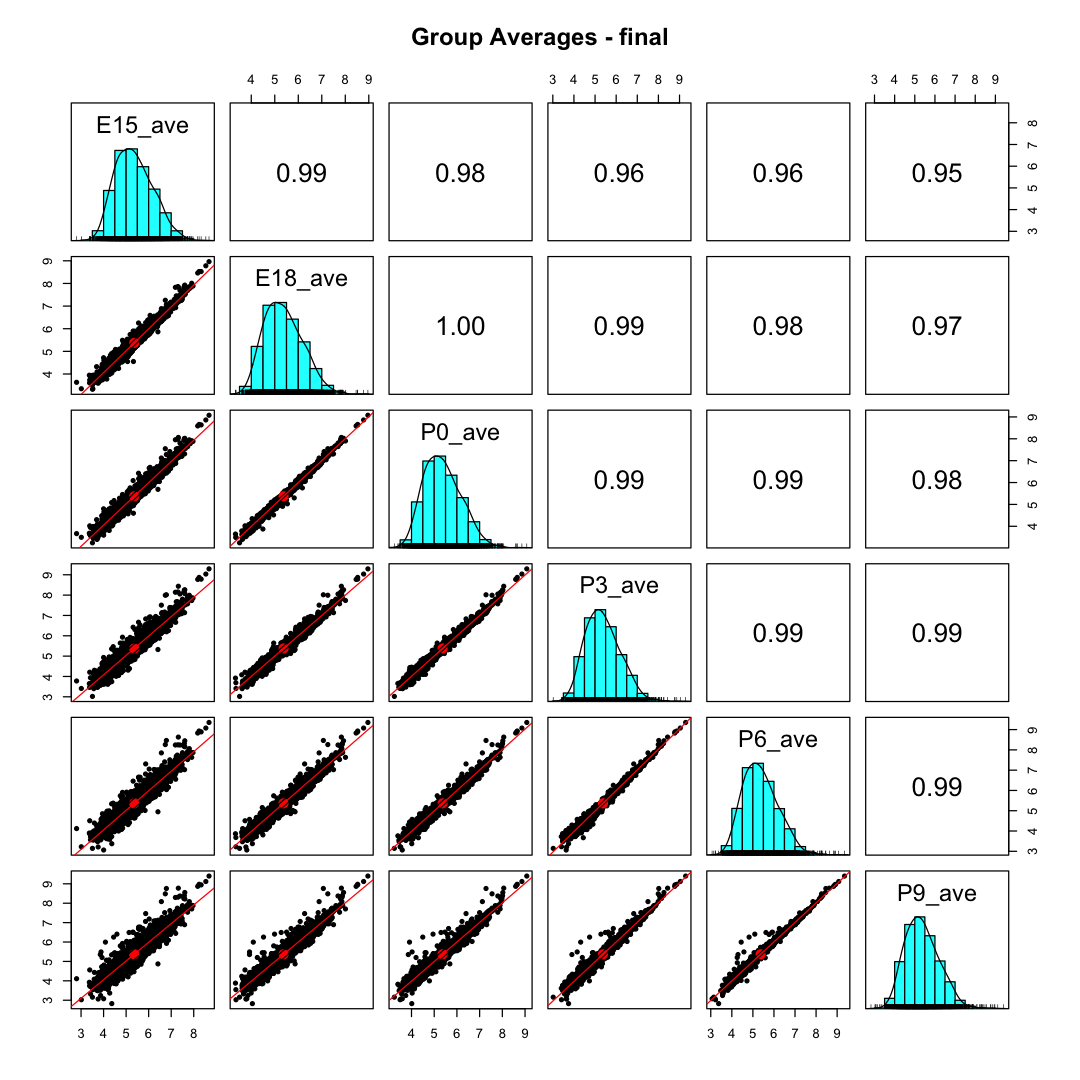

In [18]:
# make a scatter plot grid for the group averages
pairs.panels(log10(age_ave_tmm), lm = TRUE, main = "Group Averages - final")

### Group averages change with developmental age

In the scatter plot grid, each column from top-to-bottom shows progressively more scatter. The younger lenses differ from the older lenses. 

## <a name="summary"></a> Summary

Quality control checks seem okay. We can move on to the statistical testing in a new notebook.

## Log the session information

In [19]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.0.7     edgeR_3.24.3    limma_3.38.3    scales_1.1.1   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2     purrr_0.3.4    
 [9] readr_1.3.1     tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       locfit_1.5-9.4   lubridate_1.7.9  lattice_0.20-41 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.8  reprex_0.3.0    
[13] evaluate_0